# Forecast plots from MacInnis et. al. 2023


Below we reproduce the plots and tables in the main text of MacInnis et. al. 2023. This notebook also serves as an example of how to access the files included with `hdfisher`.

In [1]:
import os
from IPython.display import display
import numpy as np
import pandas as pd
from getdist import plots as ps
from getdist.gaussian_mixtures import GaussianND
from hdfisher import dataconfig, utils, fisher
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 250 # for plots in notebook

# Set up

__To save the plots__:
- Set `save_plots = True`. 
- Optionally, set the `plot_dir` to the path of the directory where you want the plots to be saved, or use the default empty `plots` directory.
- Optionally, set a `plot_root` name that all the plot file names will begin with, or use the default set below.

In [2]:
# modify the 3 lines below:
save_plots = False
plot_dir = os.path.join(os.getcwd(), 'plots')
plot_root = 'hdfisher_plots'

# leave the following un-modified:
plot_path = lambda x: os.path.join(plot_dir, x)

The `Data` class of `hdfisher.dataconfig` is used to access the files that come with `hdfisher`:

In [3]:
# initialization to access the mock data files:
data = dataconfig.Data()

In [4]:
# general settings for plots
exp_labels = {'hd': 'CMB-HD', 's4': 'CMB-S4', 'so': 'SO'}
exp_colors = {'hd': '#da0914', 's4': '#018a2d', 'so': '#fdb700'}
dpi = 300
square_figsize = (5,5) 
labelsize = 16
legendsize = 14
ticksize = 12

# Plots of CMB and lensing power spectra

Load the spectra used in Figures 1 to 5:

In [5]:
# load the theory, noise, and FG spectra, and convert C_ell -> D_ell = ell * (ell + 1) * C_ell / (2 * pi)
hd_theo_cls = data.load_all_cmb_theory_spectra('hd')
hd_theo_dls = {}
for cmb_type in hd_theo_cls.keys():
    hd_theo_dls[cmb_type] = utils.cl2dl_dict(hd_theo_cls[cmb_type])

# `include_fg` is True by default
hd_noise_cls = data.load_cmb_noise_spectra('hd', include_fg=False) 
_, hd_noise_cls['kk'] = data.load_cmb_lensing_noise_spectrum('hd', include_fg=True)
hd_noise_dls = utils.cl2dl_dict(hd_noise_cls)

hd_fg_ells, hd_fg_cl = data.load_hd_coadd_fg_spectrum(output_lmax=data.lmaxs['hd'])
hd_fg_dl = utils.cl2dl(hd_fg_cl, hd_fg_ells)

In [6]:
# bin the spectra
bin_edges = data.load_bin_edges()
hd_lbin = data.lbin('hd')

binned_hd_theo_dls = {}
for cmb_type in hd_theo_dls.keys():
    _, binned_hd_theo_dls[cmb_type] = utils.bin_theo_dict(hd_theo_dls[cmb_type]['ells'], 
                                                          hd_theo_dls[cmb_type], 
                                                          bin_edges,
                                                          lmin=data.lmins['hd'])
_, binned_hd_noise_dls = utils.bin_theo_dict(hd_noise_dls['ells'], hd_noise_dls, 
                                             bin_edges, lmin=data.lmins['hd'])  
binned_hd_fg_dl = utils.bin1d(hd_fg_ells, hd_fg_dl, bin_edges, lmin=data.lmins['hd'])

In [7]:
# get spectra error bars from the covariance matrix to use in the plot
hd_lensed_cov = data.load_cmb_covmat('hd', cmb_type='lensed')
hd_lensed_cov_blocks = utils.cov_to_blocks(hd_lensed_cov,
                                           spectra=data.cov_spectra,
                                           ell_ranges=data.ell_ranges['hd'],
                                           bin_edges=bin_edges)

hd_lensed_dl_errors = {}
for s in data.cov_spectra:
    if s in data.cmb_spectra:
        cov_block = utils.clxcl_to_dlxcl(hd_lensed_cov_blocks[s][s], hd_lbin)
    else:
        cov_block = hd_lensed_cov_blocks[s][s]
    hd_lensed_dl_errors[s] = np.sqrt(np.diag(cov_block.copy()))


## [Fig. 1] HD lensed CMB $TT$, $TE$, $EE$, $BB$ + CMB lensing $\kappa\kappa$ power spectra

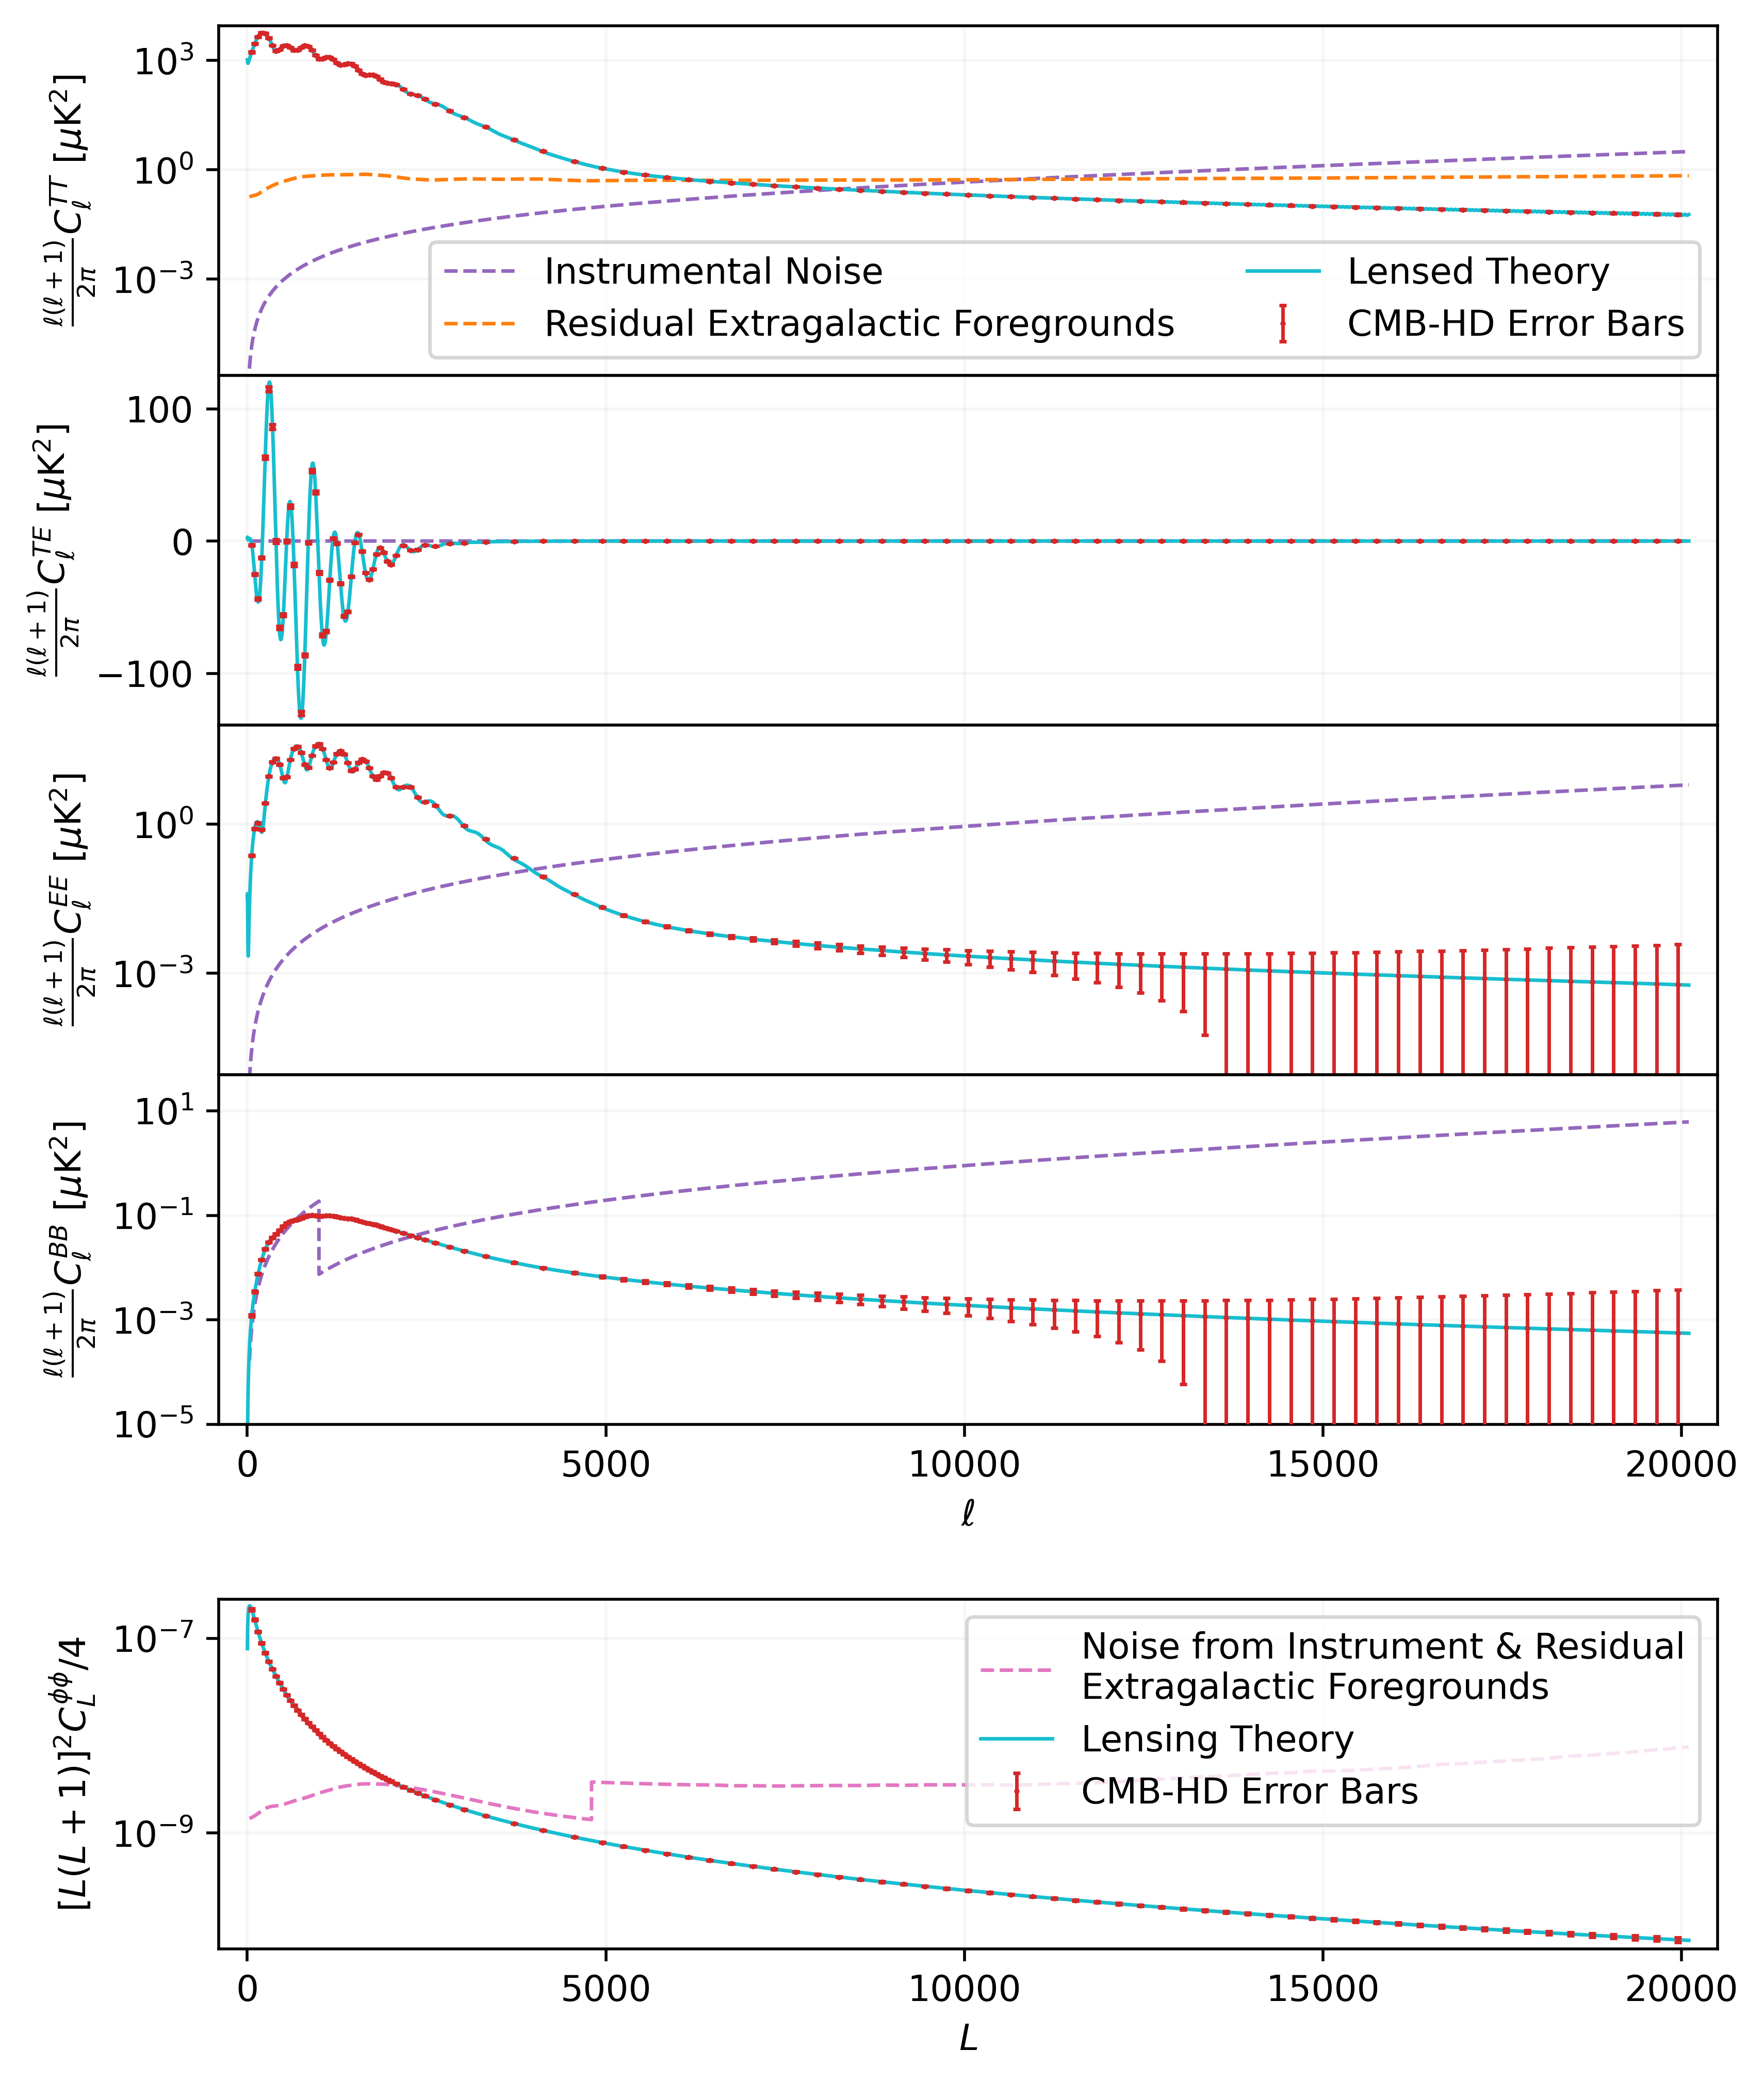

In [8]:
# setup for plot:
cmb_type = 'lensed'
theo_color = 'tab:cyan'
error_color = 'tab:red'
fg_color = 'tab:orange'
cmb_noise_color = 'tab:purple'
lensing_noise_color = 'tab:pink'
figsize = (7.5,  9.5)
fig_dpi = 500 
capsize = 1
lw = 1
imin = data.lmins['hd']
xticks = np.arange(0, data.lmaxs['hd']+1, 5000)
ylabels = {'kk': r'$\left[L (L + 1)\right]^2 C_L^{\phi\phi} / 4$'}
for s in data.cmb_spectra:
    ylabels[s] = r'$\frac{\ell (\ell + 1)}{2\pi} C_\ell^{%s}~\left[\mu\right.$K$\left.^2\right]$' % s.upper()
# positions of subplots
nsubplt = 11
plt_pos = {'tt': (1,2), 'te': (3,4), 'ee': (5,6), 'bb':  (7, 8), 'kk': (10, 11)}


# make the plot:
fig = plt.figure(figsize=figsize, dpi=fig_dpi)

# plot the cmb spectra
for i, s in enumerate(data.cmb_spectra):
    ax = fig.add_subplot(nsubplt, 1, plt_pos[s])
    ax.margins(0.02)
    
    # plot noise
    noise_label = 'Instrumental Noise' if (s == 'tt') else None
    ax.plot(hd_theo_dls[cmb_type]['ells'][imin:], hd_noise_dls[s][imin:],
            lw=lw, ls='--', color=cmb_noise_color, label=noise_label)
    if s == 'tt': # plot FGs
        ax.plot(hd_theo_dls[cmb_type]['ells'][imin:], hd_fg_dl[imin:],
                lw=lw, ls='--', color=fg_color,
                label='Residual Extragalactic Foregrounds')
    # plot unbinned theory spectra + binned error bars
    theo_label = f'{cmb_type.capitalize()} Theory' if (s == 'tt') else None
    ax.plot(hd_theo_dls[cmb_type]['ells'][2:], hd_theo_dls[cmb_type][s][2:],
            lw=lw, color=theo_color, label=theo_label)
    err_label = 'CMB-HD Error Bars' if (s == 'tt') else None
    ax.errorbar(hd_lbin, binned_hd_theo_dls[cmb_type][s], 
                yerr=hd_lensed_dl_errors[s], lw=0.8, elinewidth=lw, 
                ls='none', marker='.', markersize=1, zorder=5,
                color=error_color, label=err_label, capsize=capsize)
    
    if s != 'te':
        ax.set_yscale('log')
    # manually adjust y axis range
    if s == 'ee':
        ax.set_ylim([9e-6, 1e2])
    if s == 'bb':
        ax.set_ylim([1e-5, 50])
    
    ax.set_xticks(xticks)
    ax.grid(alpha = 0.1)
    ax.set_ylabel(ylabels[s])
    if s == 'bb':
        ax.set_xticklabels(xticks)
        ax.set_xlabel(r'$\ell$')
    else:
        ax.set_xticklabels([''] * len(xticks))
    if s == 'tt':
        ax.legend(ncol=2)
    
# add some space between the cmb and lensing spectra
ax2 = fig.add_subplot(11, 1, 9)
ax2.axis('off')

# plot lensing spectrum
ax = fig.add_subplot(nsubplt, 1, plt_pos['kk'])
ax.margins(0.02)
ax.plot(hd_theo_dls[cmb_type]['ells'][imin:], hd_noise_dls['kk'][imin:], 
        lw=lw, ls='--', color=lensing_noise_color,
        label='Noise from Instrument & Residual\nExtragalactic Foregrounds')
ax.plot(hd_theo_dls[cmb_type]['ells'][2:], hd_theo_dls[cmb_type]['kk'][2:], 
        lw=lw, color=theo_color, label='Lensing Theory')
ax.errorbar(hd_lbin, binned_hd_theo_dls[cmb_type]['kk'], yerr=hd_lensed_dl_errors['kk'],
            lw=0.8, elinewidth=lw, zorder=5, ls='none', marker='.', markersize=1, 
            capsize=capsize, color=error_color, label='CMB-HD Error Bars')
ax.set_xticks(xticks)
ax.grid(alpha=0.1)
ax.legend(loc='upper right')
ax.set_ylabel(ylabels['kk'])
ax.set_xlabel(r'$L$')
ax.set_yscale('log')

plt.subplots_adjust(hspace=0, top=0.91)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig01_hd_spectra.pdf'), bbox_inches='tight', dpi=500)
plt.show()

## [Fig. 2] HD lensing noise

The H&O and HDV lensing noise curves are only used for this plot (after using them to obtain the final noise MV curve for HD), so we load them from the `plot_data` directory:

In [9]:
nlkk_path = lambda x: os.path.join(data.data_path('plot_data/lensing_noise_curves/'), x)

# H&O, only the TT estimator:
L_huok_TT, nlkk_huok_TT = np.loadtxt(nlkk_path('nlkk_HuOk_TT.txt'), unpack=True)
# H&O, coadd of estimators, excluding TT:
L_huok_MV_noTT, nlkk_huok_MV_noTT = np.loadtxt(nlkk_path('nlkk_HuOk_MV_noTT.txt'), unpack=True)

# analytic HDV from TT:
L_hdv_TT, nlkk_hdv_TT = np.loadtxt(nlkk_path('nlkk_HDV_TT.txt'), unpack=True)
# HDV TT from sims:
L_hdv_TT_sims, nlkk_hdv_TT_sims = np.loadtxt(nlkk_path('nlkk_HDV_TT_from_sims.txt'), unpack=True)

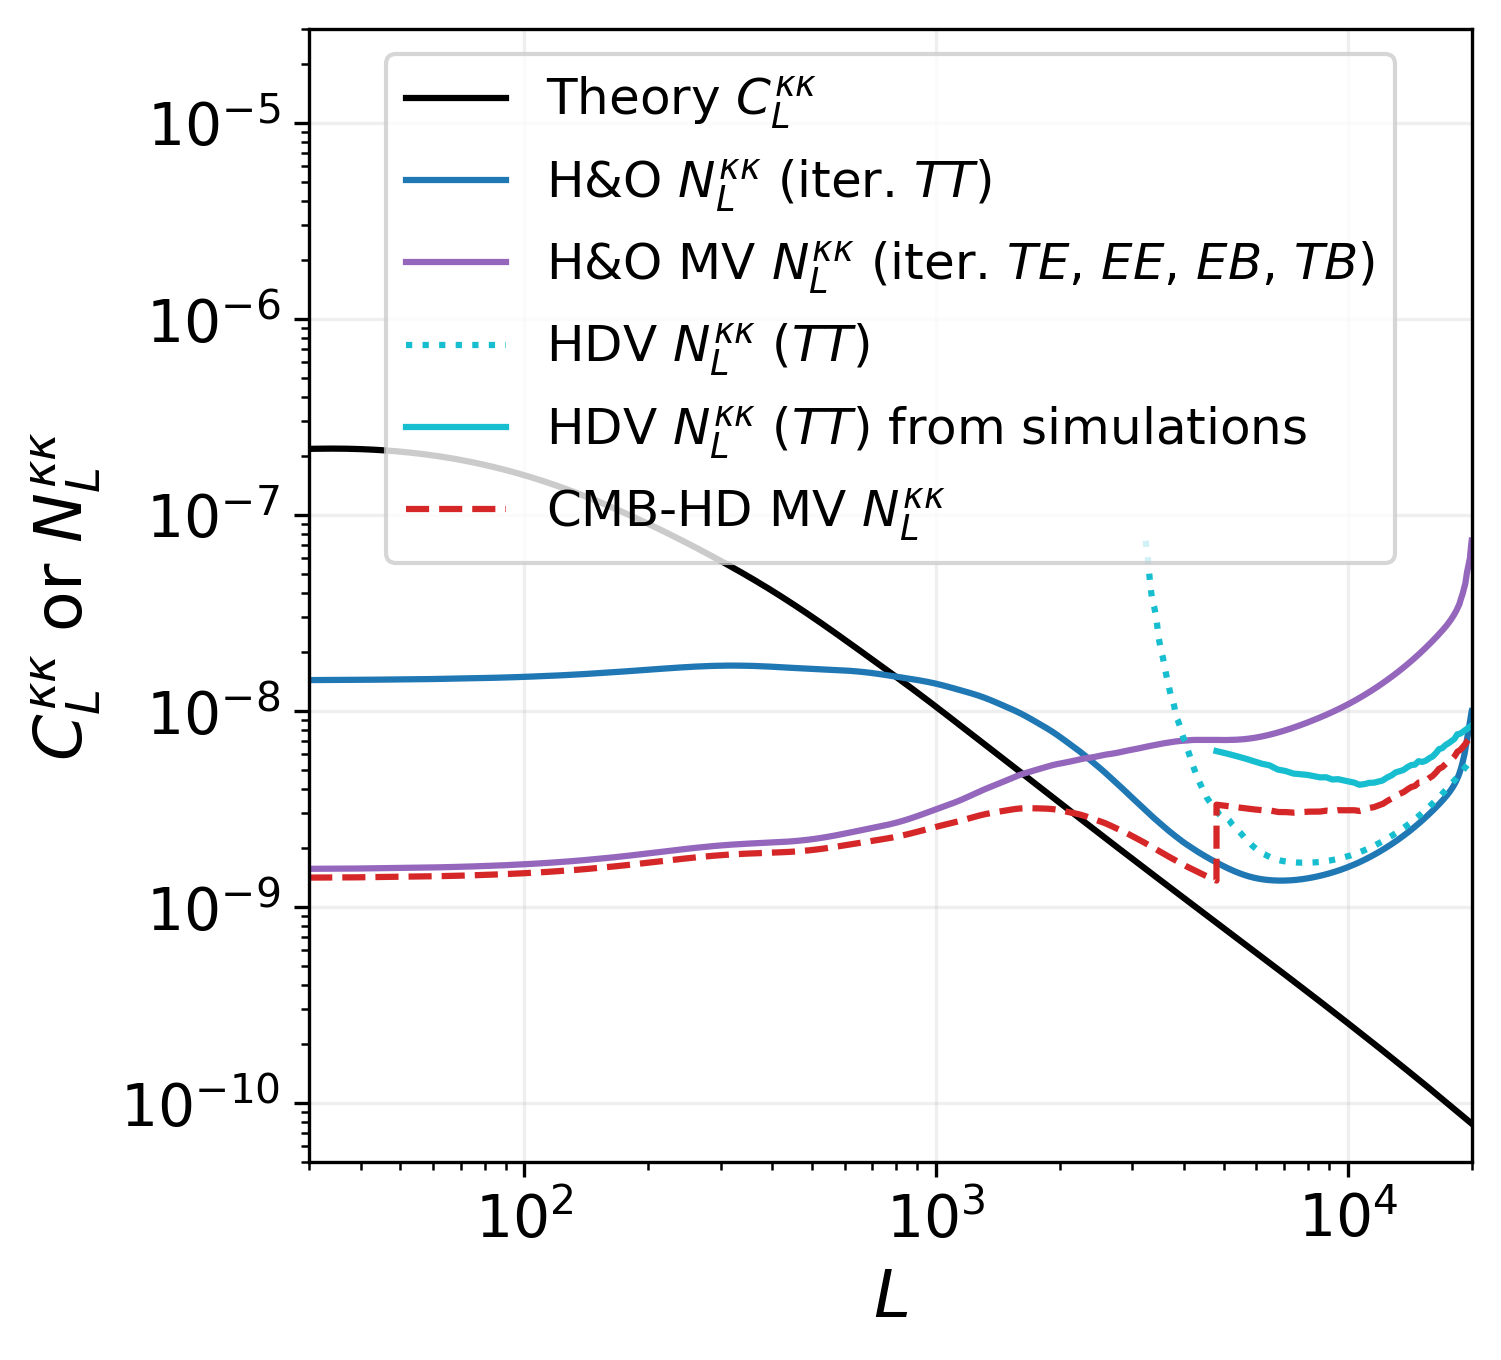

In [10]:
Lmin = data.lmins['hd']
Lmax = data.Lmaxs['hd']
xticks = np.array([30, 5000, 10000, 15000, 20000])


fig = plt.figure(figsize=square_figsize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)

# clkk theory
ax.plot(hd_theo_cls['lensed']['ells'][2:], hd_theo_cls['lensed']['kk'][2:],
        color='k', label=r'Theory $C_L^{\kappa\kappa}$')
# H&O curves begin at L = 0
ax.plot(L_huok_TT[Lmin:Lmax+1], nlkk_huok_TT[Lmin:Lmax+1],
        color='tab:blue', label=r'H&O $N_L^{\kappa\kappa}$ (iter. $TT$)')
ax.plot(L_huok_MV_noTT[Lmin:Lmax+1], nlkk_huok_MV_noTT[Lmin:Lmax+1],
        color='tab:purple', label=r'H&O MV $N_L^{\kappa\kappa}$ (iter. $TE$, $EE$, $EB$, $TB$)')
# the HDV curves begin at higher L
ax.plot(L_hdv_TT, nlkk_hdv_TT, ':', color='tab:cyan', label=r'HDV $N_L^{\kappa\kappa}$ ($TT$)')
ax.plot(L_hdv_TT_sims, nlkk_hdv_TT_sims, color='tab:cyan', label=r'HDV $N_L^{\kappa\kappa}$ ($TT$) from simulations')
# final MV noise
ax.plot(hd_noise_cls['ells'][Lmin:Lmax+1], hd_noise_cls['kk'][Lmin:Lmax+1],
        color='tab:red', ls='--', label=r'CMB-HD MV $N_L^{\kappa\kappa}$')

ax.legend(fontsize=legendsize-2, loc='upper center')
ax.grid(alpha=0.2)
ax.set_xlabel(r'$L$', fontsize=labelsize)
ax.set_ylabel(r'$C_L^{\kappa\kappa}$ or $N_L^{\kappa\kappa}$', fontsize=labelsize)
ax.set_xticks(xticks)
ax.tick_params(labelsize=ticksize+2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([5e-11, 3e-5])
ax.set_xlim([30,20000])

if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig02_lensing_noise.pdf'), bbox_inches='tight', dpi=dpi)
plt.show()


## [Fig. 3] Residual lensing power

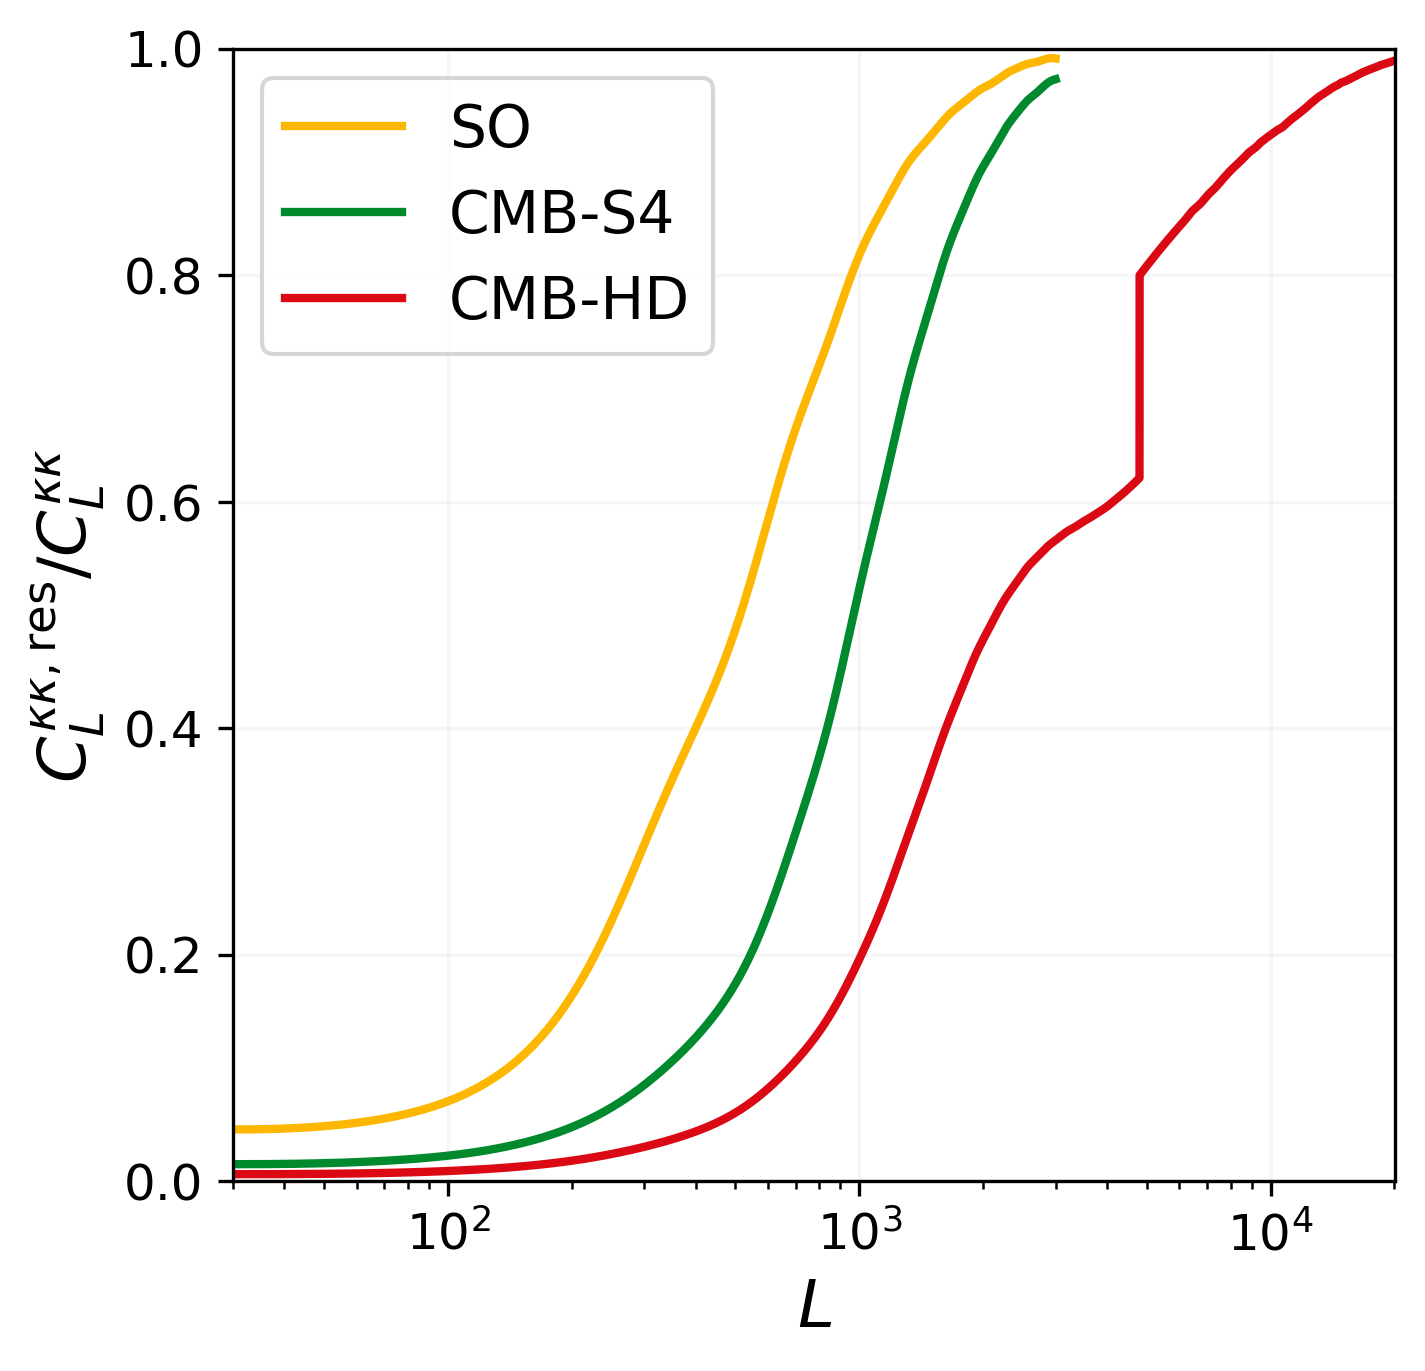

In [11]:
plt_lmin = data.lmins['hd']
plt_lmax = data.lmaxs['hd']
xticks = np.arange(0, plt_lmax + 1, 5000)
xticks[0] = plt_lmin
yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

fig = plt.figure(figsize=square_figsize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
for exp in data.cmb_exps:
    # load the spectra:
    L, clkk_res = data.load_residual_cmb_lensing_spectrum(exp)
    clkk = data.load_cmb_theory_spectra(exp, 'lensed')['kk']
    Lmax = data.Lmaxs[exp]
    ax.plot(L[plt_lmin:Lmax+1], clkk_res[plt_lmin:Lmax+1]/clkk[plt_lmin:Lmax+1],
            label=exp_labels[exp], color=exp_colors[exp], lw=2)
ax.legend(fontsize=legendsize)
ax.grid(alpha=0.1)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xticks, fontsize=ticksize)
ax.set_yticklabels(yticks, fontsize=ticksize)
ax.set_xlim([plt_lmin, plt_lmax+1])
ax.set_ylim([0,1])
ax.set_xscale('log')
ax.set_xlabel(r'$L$', fontsize=labelsize)
ax.set_ylabel(r'$C_L^{\kappa\kappa,\mathrm{res}} / C_L^{\kappa\kappa}$', fontsize=labelsize)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig03_residual_clkk.pdf'), bbox_inches='tight', dpi=500)
plt.show()

## [Fig. 4] Efficacy of delensing for HD $TT$, $TE$, $EE$ spectra

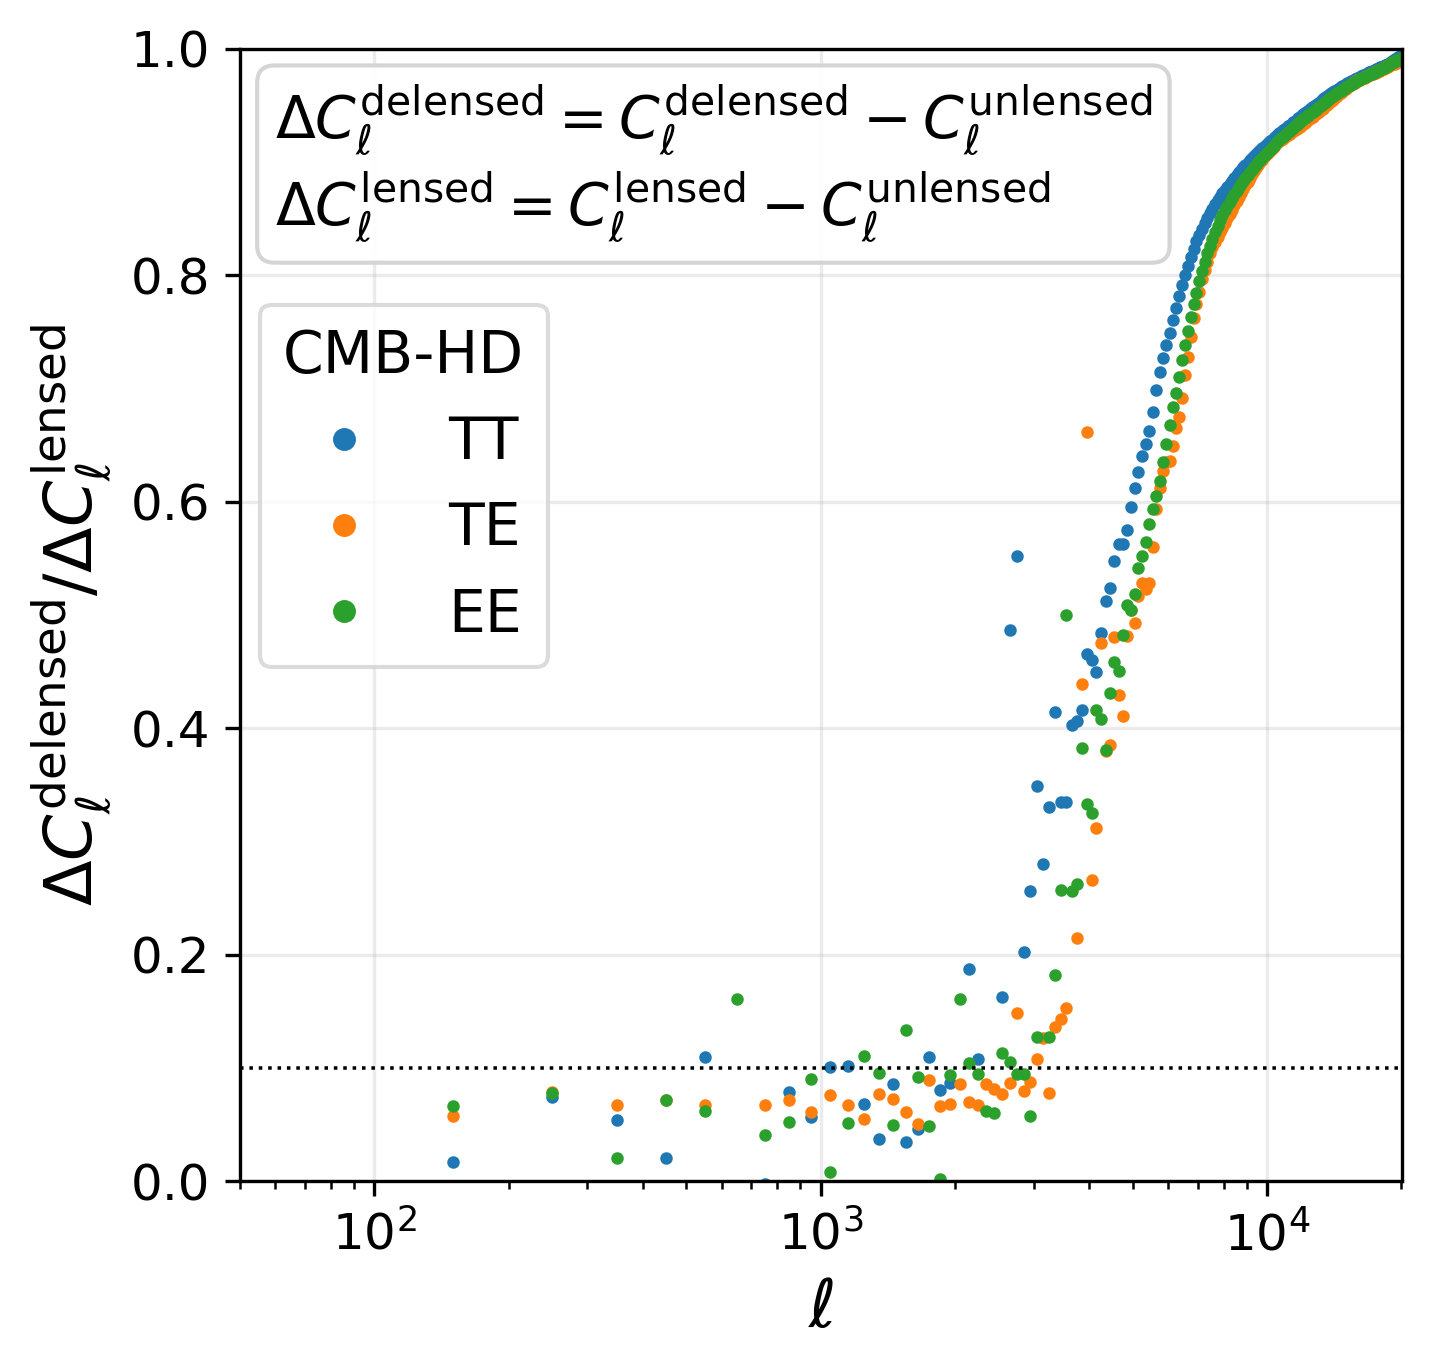

In [12]:
# we use the binning below because we're taking the ratio of two curves that cross zero at approximately the same multipoles
imin = data.lmins['hd']
imax = data.lmaxs['hd']
plt_ells = np.arange(imax+1)
bin_width = 100
plt_bin_edges = np.arange(0, imax+1, bin_width)
plt_bmat = utils.binning_matrix(plt_bin_edges, lmin=imin, lmax=imax, start_at_ell=2)
plt_lbin = plt_bmat @ plt_ells[2:]
plt_colors = {'tt': 'tab:blue', 'te': 'tab:orange', 'ee': 'tab:green'}
legend_title_fontsize = 14

fig = plt.figure(figsize=square_figsize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
for s in ['tt', 'te', 'ee']:
    delta_cl_delensed = hd_theo_cls['delensed'][s][2:] - hd_theo_cls['unlensed'][s][2:]
    delta_cl_lensed = hd_theo_cls['lensed'][s][2:] - hd_theo_cls['unlensed'][s][2:]
    cl_ratio = plt_bmat @ (delta_cl_delensed / delta_cl_lensed)
    # plot the points
    ax.plot(plt_lbin, cl_ratio, '.', ls='none', color=plt_colors[s], markersize=4)
    # put it on the legend
    ax.plot([], [], '.', ls='none', color=plt_colors[s], markersize=9, label=s.upper())

txt = r'$\Delta C_\ell^\mathrm{delensed} = C_\ell^\mathrm{delensed} - C_\ell^\mathrm{unlensed}$' +'\n'+ '$\Delta C_\ell^\mathrm{lensed} = C_\ell^\mathrm{lensed} - C_\ell^\mathrm{unlensed}$'
props = dict(boxstyle='round', facecolor='w', alpha=0.95, edgecolor='lightgray')
ax.text(0.03, 0.97, txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.legend(fontsize=legendsize, title='CMB-HD', title_fontsize=legend_title_fontsize,
          edgecolor='lightgray', bbox_to_anchor=(0.29, 0.8))
ax.set_xlabel(r'$\ell$', fontsize=labelsize)
ax.set_ylabel(r'$\Delta C_\ell^\mathrm{delensed}/ \Delta C_\ell^\mathrm{lensed}$', fontsize=labelsize)
ax.axhline(y=0.1, color='k', ls=':', lw=0.85)
ax.set_xscale('log')
ax.grid(alpha=0.25)
ax.tick_params(labelsize=ticksize)
ax.set_ylim([0,1])
ax.set_xlim([50,imax])
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig04_hd_spectra_ratio.pdf'), bbox_inches='tight', dpi=500)
plt.show()

## [Fig. 5] Efficacy of delensing for HD $BB$ spectra

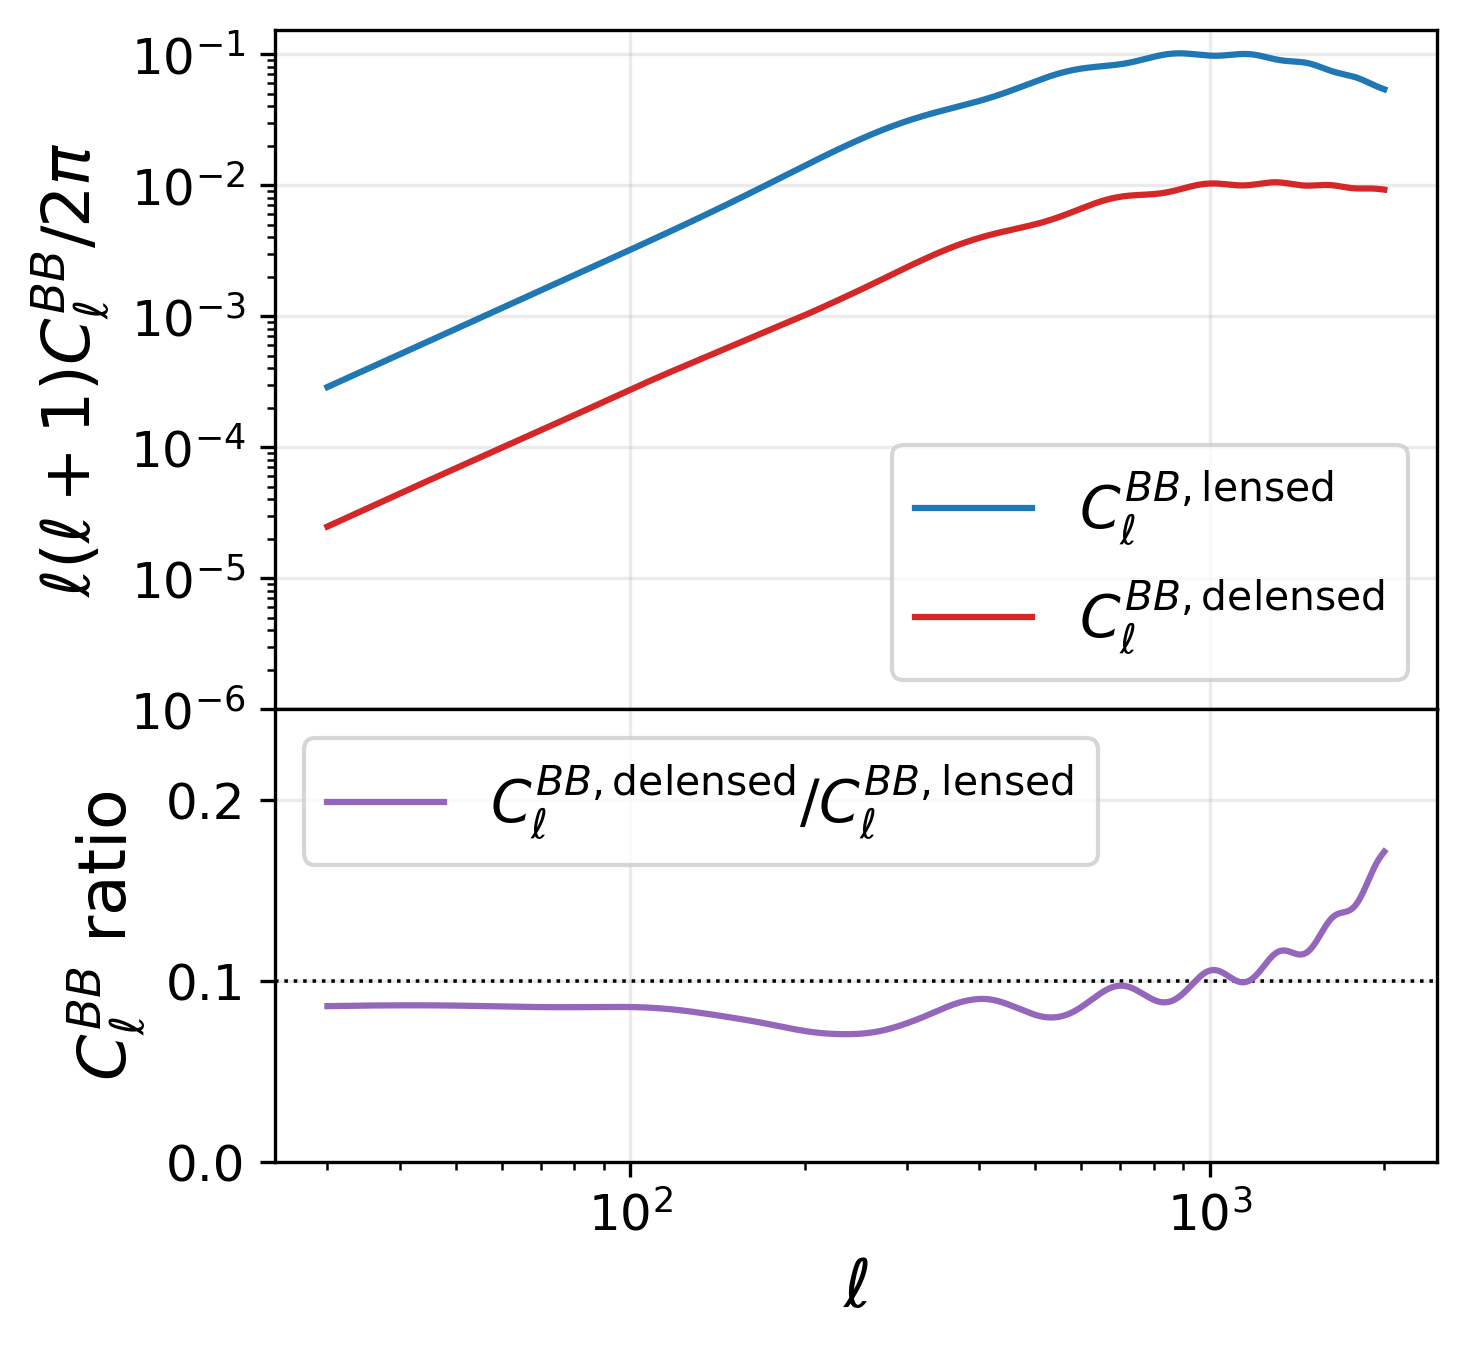

In [13]:
# setup for plot
imin = data.lmins['hd']
imax = 2000
plt_ells = np.arange(imax+1)
lw = 1.5

fig = plt.figure(figsize=square_figsize, dpi=dpi)

ax1 = fig.add_subplot(5, 1, (1,3))
ax1.plot(plt_ells[imin:imax], hd_theo_dls['lensed']['bb'][imin:imax], 
         lw=lw, label=r'$C_\ell^{BB,\mathrm{lensed}}$', color='tab:blue')
ax1.plot(plt_ells[imin:imax], hd_theo_dls['delensed']['bb'][imin:imax], 
         lw=lw, label=r'$C_\ell^{BB,\mathrm{delensed}}$', color='tab:red')
ax1.grid(alpha=0.25)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$\ell(\ell+1) C_\ell^{BB} / 2\pi$', fontsize=labelsize)
ax1.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax1.tick_params(axis='y', labelsize=ticksize)
ax1.legend(fontsize=legendsize)

ax2 = fig.add_subplot(5, 1, (4,5))
ax2.axhline(y=0.1, color='k', ls=':', lw=0.85)
ax2.plot(plt_ells[imin:imax], 
         hd_theo_dls['delensed']['bb'][imin:imax]/hd_theo_dls['lensed']['bb'][imin:imax], 
         color='tab:purple', lw=lw, 
         label=r'$C_\ell^{BB,\mathrm{delensed}} / C_\ell^{BB,\mathrm{lensed}}$')
ax2.set_ylim([0,0.25])
ax2.set_xscale('log')
ax2.grid(alpha=0.25)
ax2.set_ylabel(r'$C_\ell^{BB}$ ratio', fontsize=labelsize)
ax2.set_xlabel(r'$\ell$', fontsize=labelsize)
ax2.legend(fontsize=legendsize)
ax2.tick_params(labelsize=ticksize)

plt.subplots_adjust(hspace=0)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig05_hd_bb.pdf'), bbox_inches='tight', dpi=500)
plt.show()

# Plots and tables of parameter uncertainties from Fisher matrices

Below, we define some functions and constants to make the plots and print out the tables:

In [14]:
param_labels = {'logA': r'\ln \left(10^{10} A_\mathrm{s}\right)', 
                'ns': r'n_\mathrm{s}', 'tau': r'\tau', 
                'H0': r'H_0', 'theta': r'100\theta_\mathrm{MC}',
                'ombh2': r'\Omega_\mathrm{b} h^2', 'omch2': r'\Omega_c h^2',
                'nnu': r'N_\mathrm{eff}', 'mnu': r'\sum m_\nu',
                'HMCode_logT_AGN': r'\log_{10}(T_\mathrm{AGN}/\mathrm{K})'}

blue = '#2424f0'
red = '#d62728'
green = '#3cc03c'
orange = '#df6f0e'
purple = '#b467bd'

# for the three-parameter triangle plots, 
# we use consistent upper/lower limits for the axes
plt_params = ['H0', 'nnu', 'ns']
plt_param_lims = {'nnu': [2.975, 3.12],  'ns': [0.955, 0.975], 'H0': [65, 70]}
# order of parameters in the 8-parameter triangle plots
all_plt_params = ['ombh2', 'omch2', 'H0', 'tau', 'logA', 'ns', 'nnu', 'mnu']

# parameter contours are centered on their fiducial values:
fid_params = data.fiducial_params()
# add the fiducial value of the baryonic feedback parameter
fid_params_feedback = data.fiducial_params(feedback=True)
fid_params['HMCode_logT_AGN'] = fid_params_feedback['HMCode_logT_AGN']

# we use `getdist.gaussian_mixtures.GaussianND` to get the
# `getdist.mcsamples.MCSamples` instance for each Fisher matrix,
# which is used to make the triangle parameter plots
def getdist_samples(fisher_matrix, fisher_params):
    """Returns the `getdist.mcsamples.MCSamples` instance for the 
    `fisher_matrix` (two-dimensional array of float), with the order
    of the parameters in the rows/columns given by the list of 
    parameter names, `fisher_params`.
    """
    fids = [fid_params[p] for p in fisher_params] 
    labels = [param_labels[p] for p in fisher_params]
    samples = GaussianND(fids, fisher_matrix, is_inv_cov=True, names=fisher_params, labels=labels)
    return samples

In [15]:
# order of parameters in tables
param_list = ['ombh2', 'omch2', 'logA', 'ns', 'tau', 'H0', 'nnu', 'mnu']
# number of digits to use when rounding the uncertainty of each parameter:
ndigits = {'ombh2': 6, 'omch2': 5, 'logA': 4, 'ns': 4, 'tau': 4, 
           'H0': 2, 'theta': 6, 'nnu': 3, 'mnu': 3, 'HMCode_logT_AGN': 4}


def round_dict(d, ndigits=ndigits):
    """Given a dictionary `d` with numerical values, round each value 
    to the number of digits for that key, given by the `ndigits` dict."""
    rounded = {}
    for key, val in d.items():
        rounded[key] = round(val, ndigits[key])
    return rounded


def ratio(dict1, dict2, fill_value=None):
    """Returns a dictionary with the ratio of the values in `dict1` to those 
    in `dict2` for each key they share in common. If the keys don't match, you
    can pass a `fill_value` as a placeholder for any keys not in both dictionaries;
    otherwise leave it as `None` to exclude those keys from the returned dictionary."""
    rdict = {}
    keys1 = list(dict1.keys())
    keys2 = list(dict2.keys())
    all_keys = list(set(keys1 + keys2))
    for key in all_keys:
        if (key in dict1) and (key in dict2):
            rdict[key] = dict1[key] / dict2[key]
        elif fill_value is not None:
            rdict[key] = fill_value
    return rdict


def print_table(list_of_dicts, list_of_labels, title=None, list_of_keys=None):
    """
    Display a table of keys and values held in each dictionary in the `list_of_dicts`.
    
    Parameters
    ----------
    list_of_dicts : list of dict
        A list of dictionaries.
    list_of_labels : list of str
        A list holding a label for each dictionary in `list_of_dicts`, in
        the same order that they appear in `list_of_dicts`.
    title : str or None, default=None
        A title that is printed out above the table.
    list_of_keys : list or None, default=None
        A list of keys to use in the table. The table will only contain 
        values corresponding to the keys in `list_of_keys`, and in the same
        order. If `None`, all keys are used. In either case, the dictionaries
        in `list_of_dicts` do not need to contain the same set of keys.
    
    """
    table = pd.DataFrame(list_of_dicts, index=list_of_labels, columns=list_of_keys)
    table = table.T
    title = ' ' if title is None else title
    table.style.set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'k'),
        ('font-size', '26px')
    ]}])
    print('\n', title) 
    display(table)

## $\Lambda$CDM + $N_\mathrm{eff}$ + $\sum m_\nu$ model

### SO-like, CMB-S4-like, and CMB-HD-like delensed $TT$, $TE$, $EE$, $BB$, $\kappa\kappa$ + mock DESI BAO

For each experiment, load the Fisher matrix; use it to get the parameter uncertainties, and the `getdist.mcsamples.MCSamples` instance that is used to make the parameter triangle plots:

In [16]:
# by default, the fisher matrix for the LCDM + N_eff + m_nu set of 8 parameters is returned.
# for HD, we include the effects of residual extragalactic foregrounds by default.
fishers = {}
fisher_params = {}
param_errors = {}
samples = {}
for exp in data.cmb_exps:
    fishers[exp], fisher_params[exp] = data.load_precomputed_cmb_fisher(exp, cmb_type='delensed', use_H0=True, with_desi=True)
    param_errors[exp] = fisher.get_fisher_errors(fishers[exp], fisher_params[exp])
    samples[exp] = getdist_samples(fishers[exp], fisher_params[exp])

#### [Table 3] 

In [17]:
# list of rounded parameter uncertainties for each experiment
param_errors_list = [round_dict(param_errors[exp]) for exp in data.cmb_exps]
columns = [f'{exp_labels[exp]} + DESI' for exp in data.cmb_exps]
# HD / SO and HD / S4
ndigits_ratio = {param: 2 for param in param_list}
for exp in ['so', 's4']:
    param_error_ratios = ratio(param_errors['hd'], param_errors[exp])
    param_errors_list.append(round_dict(param_error_ratios, ndigits=ndigits_ratio))
    columns.append(f'HD / {exp.upper()}')

print_table(param_errors_list, columns, title='Delensed TT, TE, EE, BB, and kk + BAO', list_of_keys=param_list)


 Delensed TT, TE, EE, BB, and kk + BAO


,SO + DESI,CMB-S4 + DESI,CMB-HD + DESI,HD / SO,HD / S4
ombh2,0.000057,0.000039,0.000026,0.46,0.68
omch2,0.000740,0.000560,0.000410,0.56,0.74
logA,0.011700,0.011400,0.009800,0.84,0.86
ns,0.003000,0.002500,0.001300,0.44,0.53
tau,0.006100,0.006000,0.005200,0.85,0.87
H0,0.360000,0.320000,0.290000,0.82,0.93
nnu,0.043000,0.030000,0.014000,0.34,0.47
mnu,0.030000,0.029000,0.025000,0.82,0.85


#### [Fig. 7]

Note: it may take up to a few minutes to create the large triangle plots.

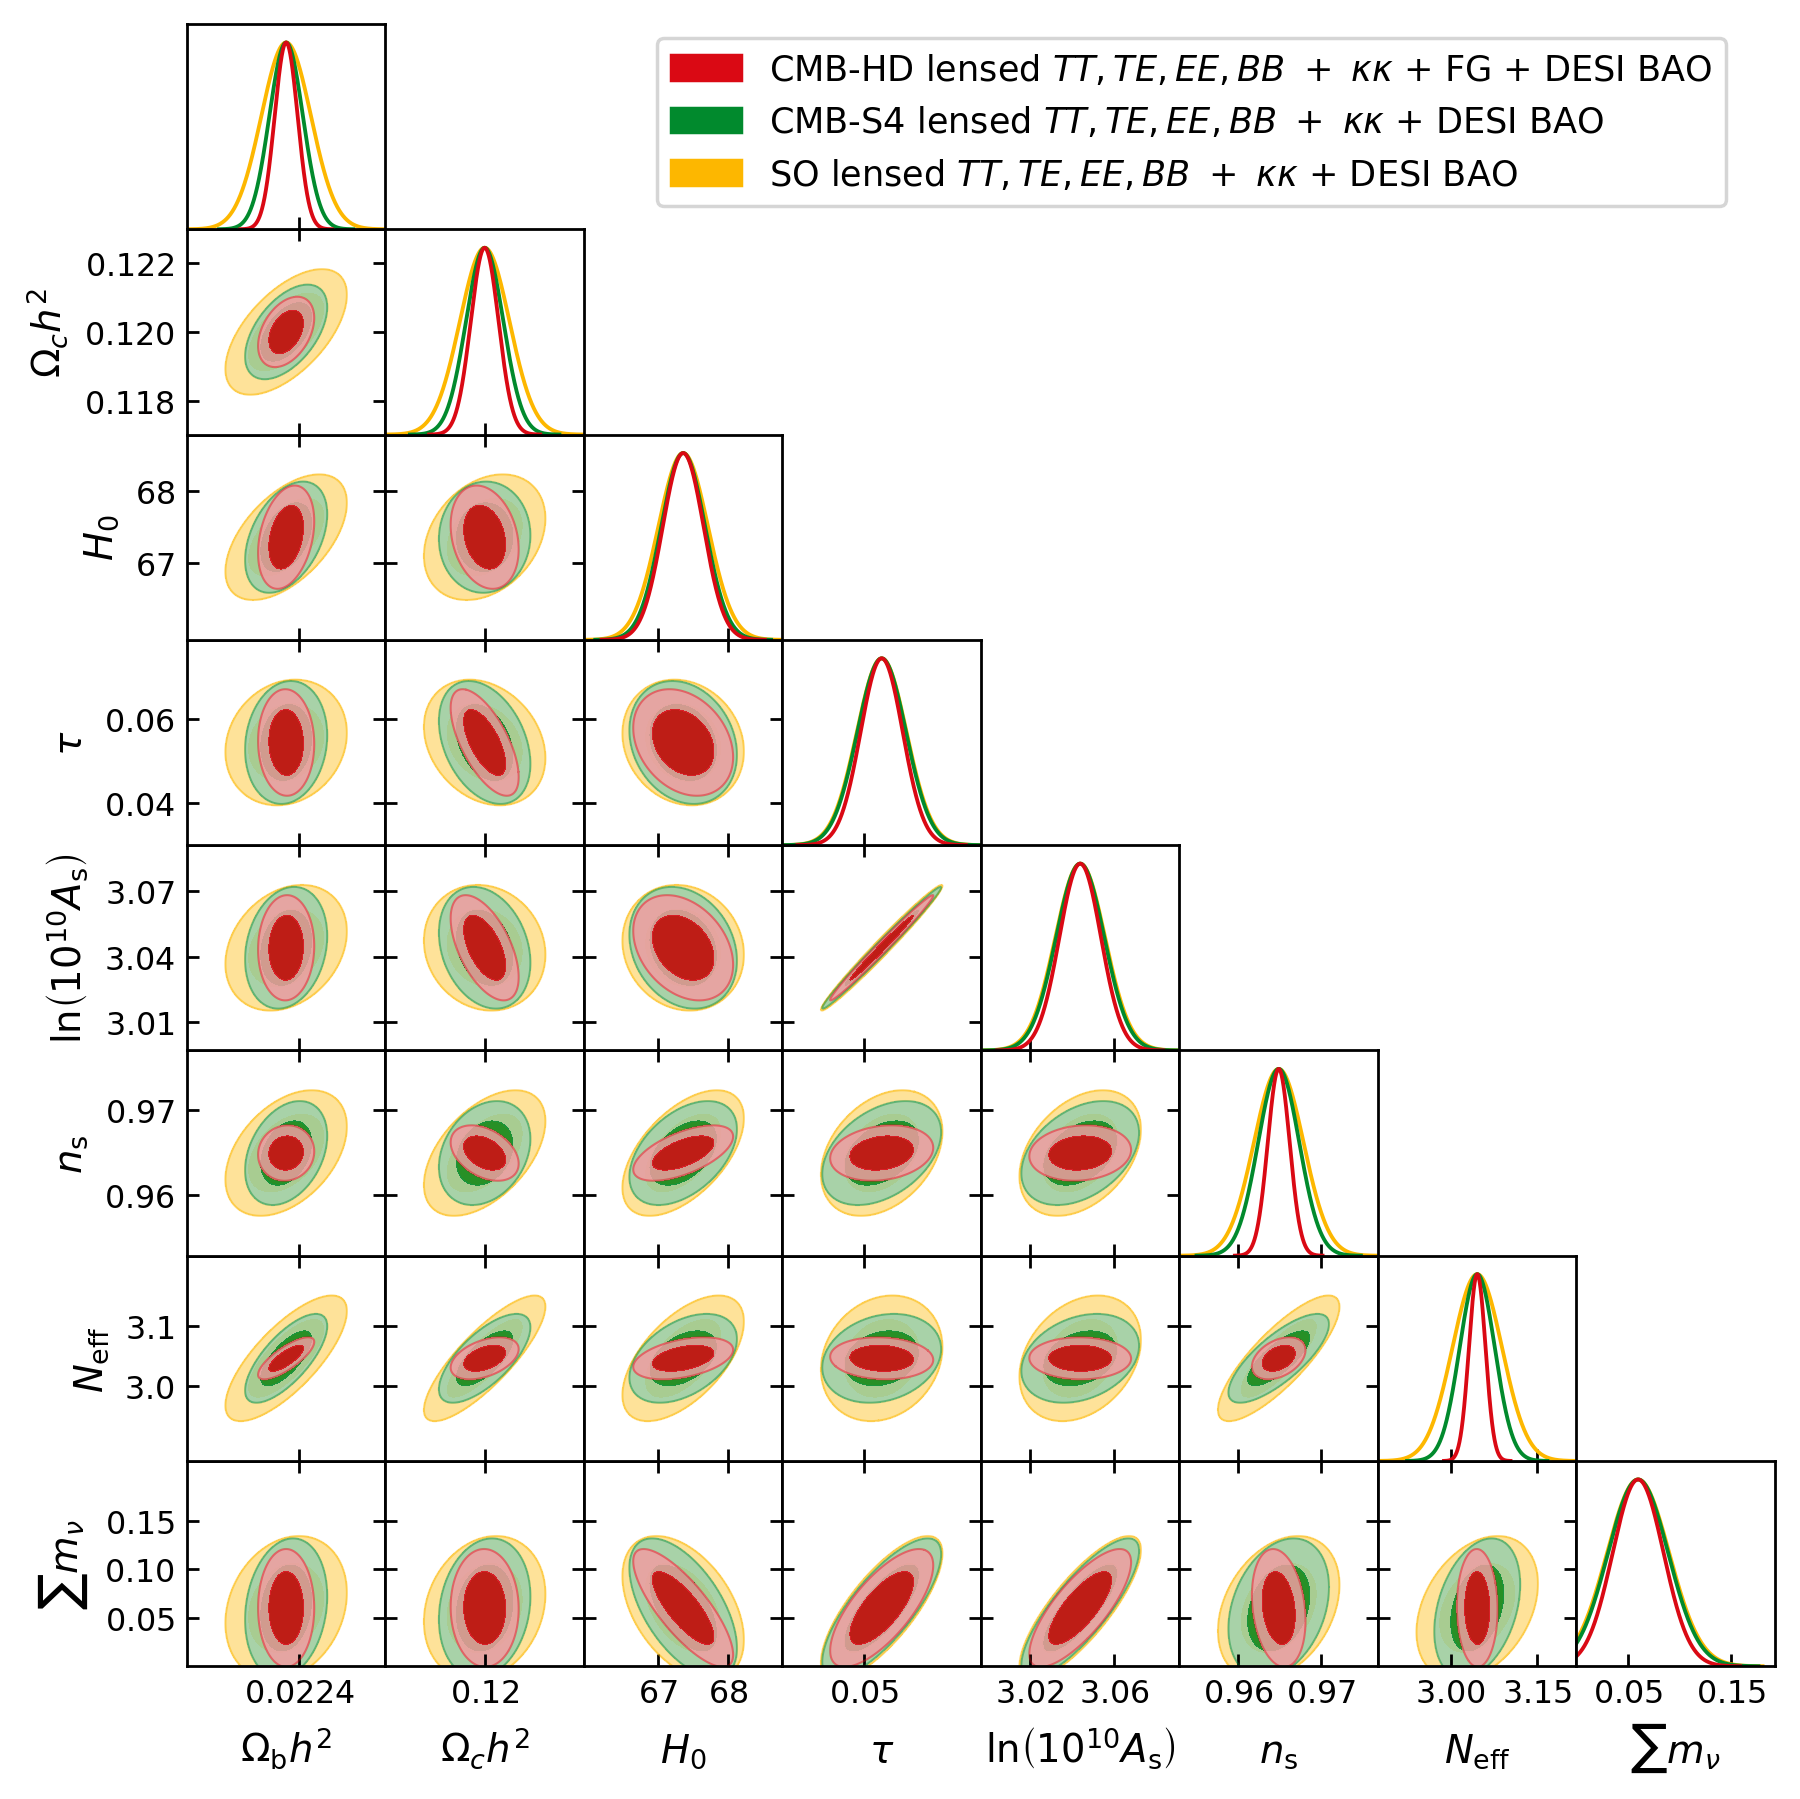

In [18]:
legend_labels = []
for exp in data.cmb_exps:
    if 'hd' in exp:
        legend_labels.append(f'{exp_labels[exp]} {cmb_type} '+r'$TT, TE, EE, BB~+~\kappa\kappa$ + FG + DESI BAO')
    else:
        legend_labels.append(f'{exp_labels[exp]} {cmb_type} '+r'$TT, TE, EE, BB~+~\kappa\kappa$ + DESI BAO')

g = ps.get_subplot_plotter(width_inch=7)
g.settings.scaling_factor = 1.1
g.settings.legend_fontsize = 13
g.settings.axes_fontsize = 12
g.settings.constrained_layout = True
g.triangle_plot([samples[exp] for exp in data.cmb_exps],
                params=all_plt_params,
                filled=True, param_limits={'mnu': [0, None]},
                diag1d_kwargs={'lws': [1.1, 1.1, 1.1]},
                contour_colors=[exp_colors[exp] for exp in data.cmb_exps],
                legend_loc=(0.365, 0.885),
                legend_labels=legend_labels, label_order=-1)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig07_sos4hd.pdf'), bbox_inches='tight', dpi=500)
plt.show()
                

### CMB-HD-like $TT$, $TE$, $EE$, $BB$, $\kappa\kappa$ (+ mock DESI BAO)

In the following cases for CMB-HD, we include the effect of residual extragalactic foregrounds and use the multipole ranges $\ell \in [30, 20100]$ and $L \in [30, 20100]$, unless stated otherwise:
- Lensed $TT$, $TE$, $EE$, $BB$ and $\kappa\kappa$, with and without the effect of residual extragalactic foregrounds.
- Delensed $TT$, $TE$, $EE$, $BB$ and $\kappa\kappa$.
- Lensed and delensed $TT$, $TE$, $EE$, $BB$ and $\kappa\kappa$ + DESI BAO.
  - Delensed $TT$, $TE$, $EE$, $BB$ and $\kappa\kappa$ + DESI BAO for $\ell_\mathrm{max}, L_\mathrm{max} = 1000,~3000,~5000,~10000$.

For each case above, load the Fisher matrix; use it to get the parameter uncertainties, and the `getdist.mcsamples.MCSamples` instance that is used to make the parameter triangle plots:

In [19]:
hd_fishers = {}
hd_fisher_params = {}
hd_param_errors = {}
hd_samples = {}

for cmb_type in ['lensed', 'delensed']:
    # without bao:
    hd_fishers[cmb_type], hd_fisher_params[cmb_type] = data.load_precomputed_cmb_fisher('hd', cmb_type=cmb_type, use_H0=True)
    hd_param_errors[cmb_type] = fisher.get_fisher_errors(hd_fishers[cmb_type], hd_fisher_params[cmb_type])
    hd_samples[cmb_type] = getdist_samples(hd_fishers[cmb_type], hd_fisher_params[cmb_type])
    # with bao:
    hd_fishers[f'{cmb_type}_desi'], hd_fisher_params[f'{cmb_type}_desi'] = data.load_precomputed_cmb_fisher('hd', cmb_type=cmb_type, with_desi=True, use_H0=True)
    hd_param_errors[f'{cmb_type}_desi'] = fisher.get_fisher_errors(hd_fishers[f'{cmb_type}_desi'], hd_fisher_params[f'{cmb_type}_desi'])
    hd_samples[f'{cmb_type}_desi'] = getdist_samples(hd_fishers[f'{cmb_type}_desi'], hd_fisher_params[f'{cmb_type}_desi'])
# lensed, without FG or bao:
hd_fishers['lensed_nofg'], hd_fisher_params['lensed_nofg'] = data.load_precomputed_cmb_fisher('hd', cmb_type='lensed', include_fg=False, use_H0=True)
hd_param_errors['lensed_nofg'] = fisher.get_fisher_errors(hd_fishers['lensed_nofg'], hd_fisher_params['lensed_nofg'])
hd_samples['lensed_nofg'] = getdist_samples(hd_fishers['lensed_nofg'], hd_fisher_params['lensed_nofg'])
# delensed with bao for different maximum multipole values:
for hd_lmax in data.hd_lmaxs:
    hd_fishers[f'delensed_desi_{hd_lmax}'], hd_fisher_params[f'delensed_desi_{hd_lmax}'] = data.load_precomputed_cmb_fisher('hd', cmb_type='delensed', with_desi=True, hd_lmax=hd_lmax, use_H0=True)
    hd_param_errors[f'delensed_desi_{hd_lmax}'] = fisher.get_fisher_errors(hd_fishers[f'delensed_desi_{hd_lmax}'], hd_fisher_params[f'delensed_desi_{hd_lmax}'])
    hd_samples[f'delensed_desi_{hd_lmax}'] = getdist_samples(hd_fishers[f'delensed_desi_{hd_lmax}'], hd_fisher_params[f'delensed_desi_{hd_lmax}'])

#### Parameter tables

##### [Table 4]

Compare the effects of foregrounds, delensing, and including DESI BAO:

In [20]:
title = 'CMB-HD TT, TE, EE, BB, kk'
columns = ['Lensed', 'Lensed + FG', 'Delensed + FG', 
           'Delensed + FG + DESI BAO', 'Delensed + FG + DESI BAO (lmax = 10,000)']
hd_keys = ['lensed_nofg', 'lensed', 'delensed', 
           'delensed_desi', 'delensed_desi_10000']
param_errors_list = [round_dict(hd_param_errors[key]) for key in hd_keys]
print_table(param_errors_list, columns, title=title, list_of_keys=param_list)



 CMB-HD TT, TE, EE, BB, kk


,Lensed,Lensed + FG,Delensed + FG,Delensed + FG + DESI BAO,"Delensed + FG + DESI BAO (lmax = 10,000)"
ombh2,0.000032,0.000033,0.000027,0.000026,0.000026
omch2,0.000640,0.000650,0.000580,0.000410,0.000410
logA,0.011000,0.011300,0.010800,0.009800,0.010100
ns,0.002300,0.002400,0.002100,0.001300,0.001400
tau,0.005600,0.005700,0.005400,0.005200,0.005400
H0,0.720000,0.740000,0.650000,0.290000,0.290000
nnu,0.017000,0.018000,0.015000,0.014000,0.015000
mnu,0.050000,0.051000,0.047000,0.025000,0.026000


##### [Table 9]

Compare lensed and delensed, with foreground effects and DESI BAO:

In [21]:
title = 'CMB-HD TT, TE, EE, BB, kk + FG + DESI BAO'
columns = ['Lensed + FG + DESI BAO',  'Delensed + FG + DESI BAO']
hd_keys = ['lensed_desi', 'delensed_desi']
param_errors_list = [round_dict(hd_param_errors[key]) for key in hd_keys]
print_table(param_errors_list, columns, title=title, list_of_keys=param_list)



 CMB-HD TT, TE, EE, BB, kk + FG + DESI BAO


,Lensed + FG + DESI BAO,Delensed + FG + DESI BAO
ombh2,0.000032,0.000026
omch2,0.000450,0.000410
logA,0.010300,0.009800
ns,0.001400,0.001300
tau,0.005500,0.005200
H0,0.300000,0.290000
nnu,0.017000,0.014000
mnu,0.025000,0.025000


##### [Table 10]

Compare delensed + DESI BAO at different values of $\ell_\mathrm{max}$ and $L_\mathrm{max}$:

In [22]:
title = 'CMB-HD delensed TT, TE, EE, BB, kk + FG + DESI BAO'
columns = ['lmax = 1,000', 'lmax = 3,000', 'lmax = 5,000', 'lmax = 10,000', 'lmax = 20,000']
hd_keys =  [f'delensed_desi_{lmax}' for lmax in data.hd_lmaxs] + ['delensed_desi']
param_errors_list = [round_dict(hd_param_errors[key]) for key in hd_keys]
print_table(param_errors_list, columns, title=title, list_of_keys=param_list)



 CMB-HD delensed TT, TE, EE, BB, kk + FG + DESI BAO


,"lmax = 1,000","lmax = 3,000","lmax = 5,000","lmax = 10,000","lmax = 20,000"
ombh2,0.000158,0.000039,0.000027,0.000026,0.000026
omch2,0.002370,0.000540,0.000420,0.000410,0.000410
logA,0.013800,0.011300,0.010800,0.010100,0.009800
ns,0.004800,0.002300,0.001800,0.001400,0.001300
tau,0.006500,0.006000,0.005700,0.005400,0.005200
H0,0.800000,0.320000,0.290000,0.290000,0.290000
nnu,0.152000,0.030000,0.018000,0.015000,0.014000
mnu,0.037000,0.029000,0.028000,0.026000,0.025000


#### [Fig. 11] Triangle plot for all parameters

Note: it may take up to a few minutes to create the large triangle plots.

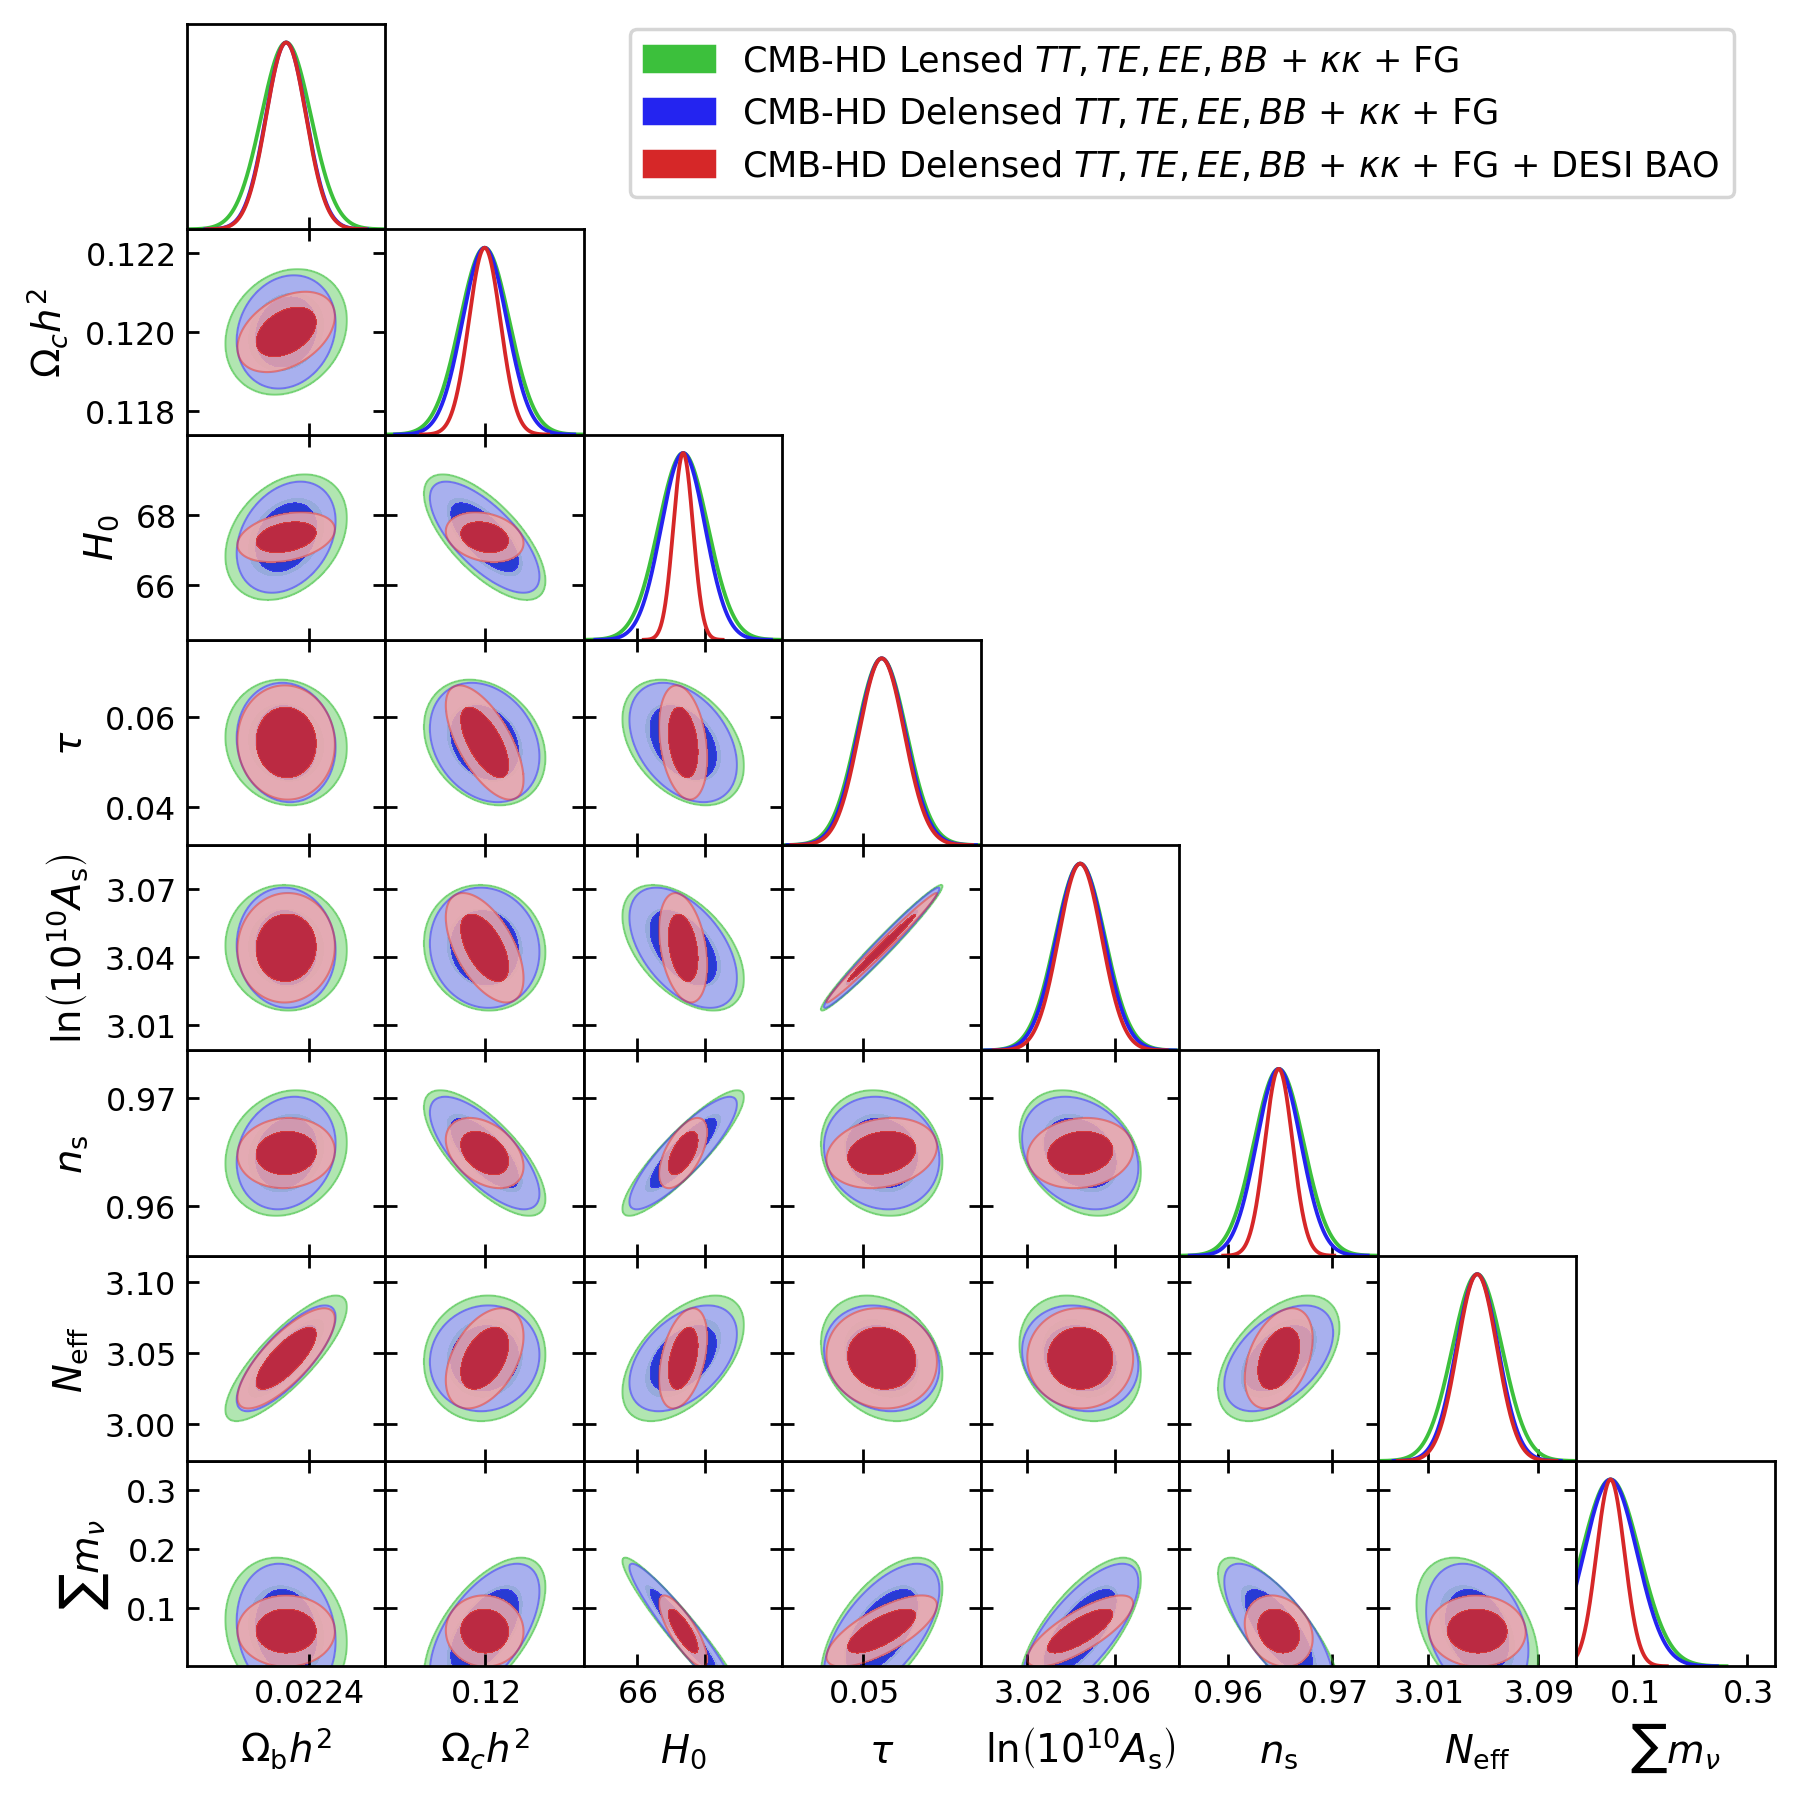

In [23]:
hd_keys = ['lensed', 'delensed', 'delensed_desi']
legend_labels = ['CMB-HD Lensed ' + r'$TT, TE, EE, BB$ + $\kappa\kappa$ + FG',
                 'CMB-HD Delensed ' + r'$TT, TE, EE, BB$ + $\kappa\kappa$ + FG',
                 'CMB-HD Delensed ' + r'$TT, TE, EE, BB$ + $\kappa\kappa$ + FG + DESI BAO']
g = ps.get_subplot_plotter(width_inch=7)
g.settings.scaling_factor = 1.1
g.settings.legend_fontsize = 13
g.settings.axes_fontsize = 12
g.settings.constrained_layout = True
g.triangle_plot([hd_samples[key] for key in hd_keys],
                params=all_plt_params,
                filled=True, param_limits={'mnu': [0, 0.35]},
                diag1d_kwargs={'lws': [1.1, 1.1, 1.1]},
                contour_colors=[green, blue, red],
                legend_loc=(0.35, 0.89),
                legend_labels=legend_labels)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig11_hd_lensed_delensed_desi.pdf'), bbox_inches='tight', dpi=500)
plt.show()

#### Triangle plots for $H_0$, $N_\mathrm{eff}$, $n_\mathrm{s}$

##### [Fig. 8] Lensed and Lensed + FG

Lensed, without and with including the effects of residual extragalactic foregrounds:

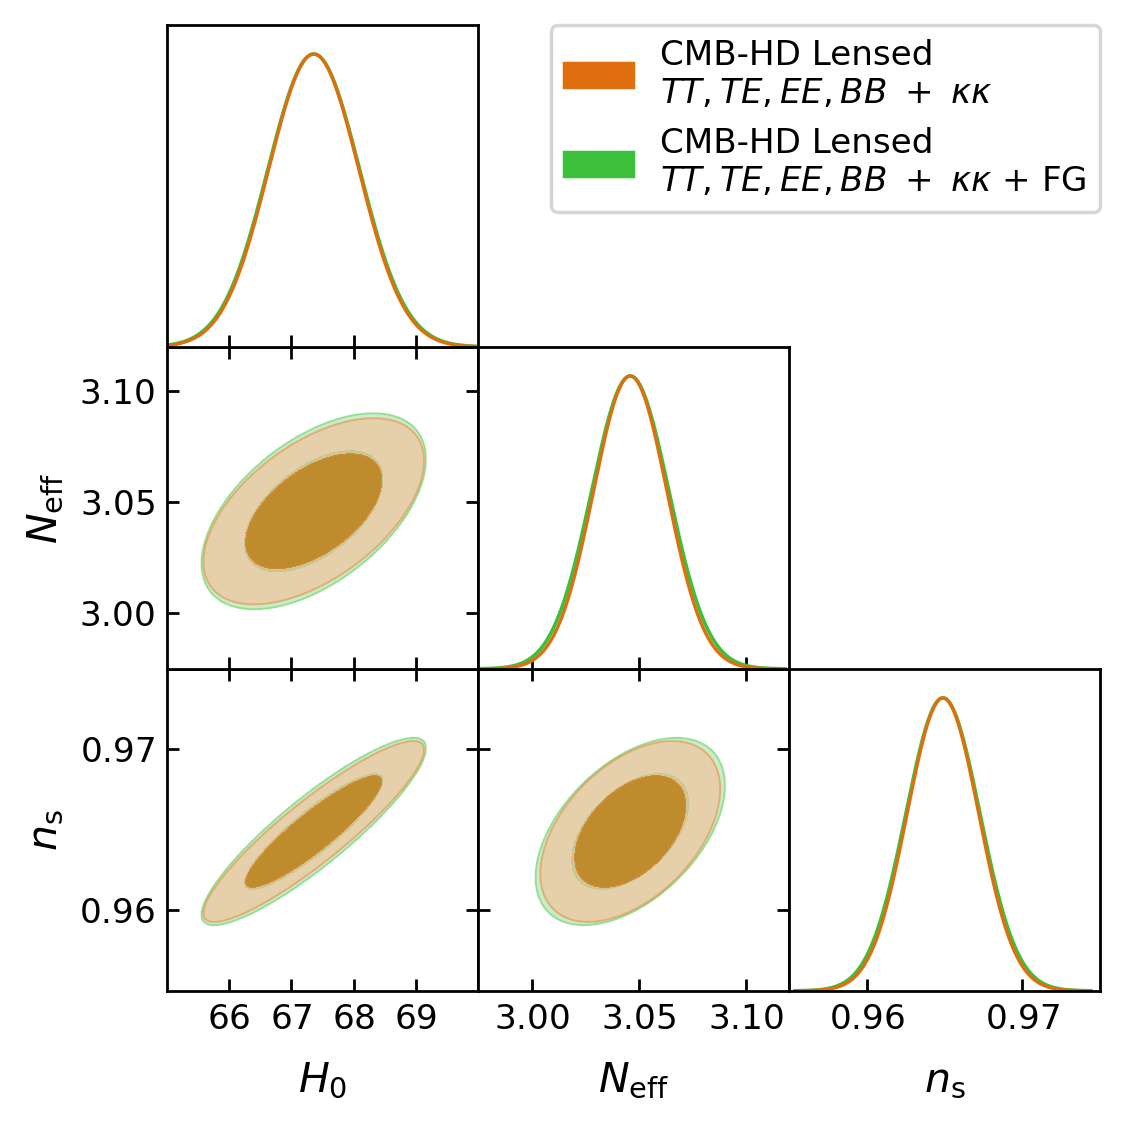

In [24]:
legend_labels = ['CMB-HD Lensed\n' + r'$TT, TE, EE, BB~+~\kappa\kappa$ + FG', 
                 'CMB-HD Lensed\n' + r'$TT, TE, EE, BB~+~\kappa\kappa$']
plt_colors = [green, orange]
plt_samples = [hd_samples['lensed'], hd_samples['lensed_nofg']]

g = ps.get_subplot_plotter(width_inch=4.6)
g.settings.scaling_factor = 1.1
g.settings.axes_fontsize = 12
g.triangle_plot(plt_samples, 
                params=plt_params, 
                filled=True, 
                param_limits=plt_param_lims,
                contour_args={'alpha': 0.7},
                diag1d_kwargs={'lws': [1.05, 0.95]},
                label_order=-1,
                contour_colors=plt_colors, 
                legend_labels=legend_labels)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig08_hd_lensed_fg.pdf'), bbox_inches='tight', dpi=dpi)
plt.show()

##### [Fig. 9] Lensed + FG and Delensed + FG

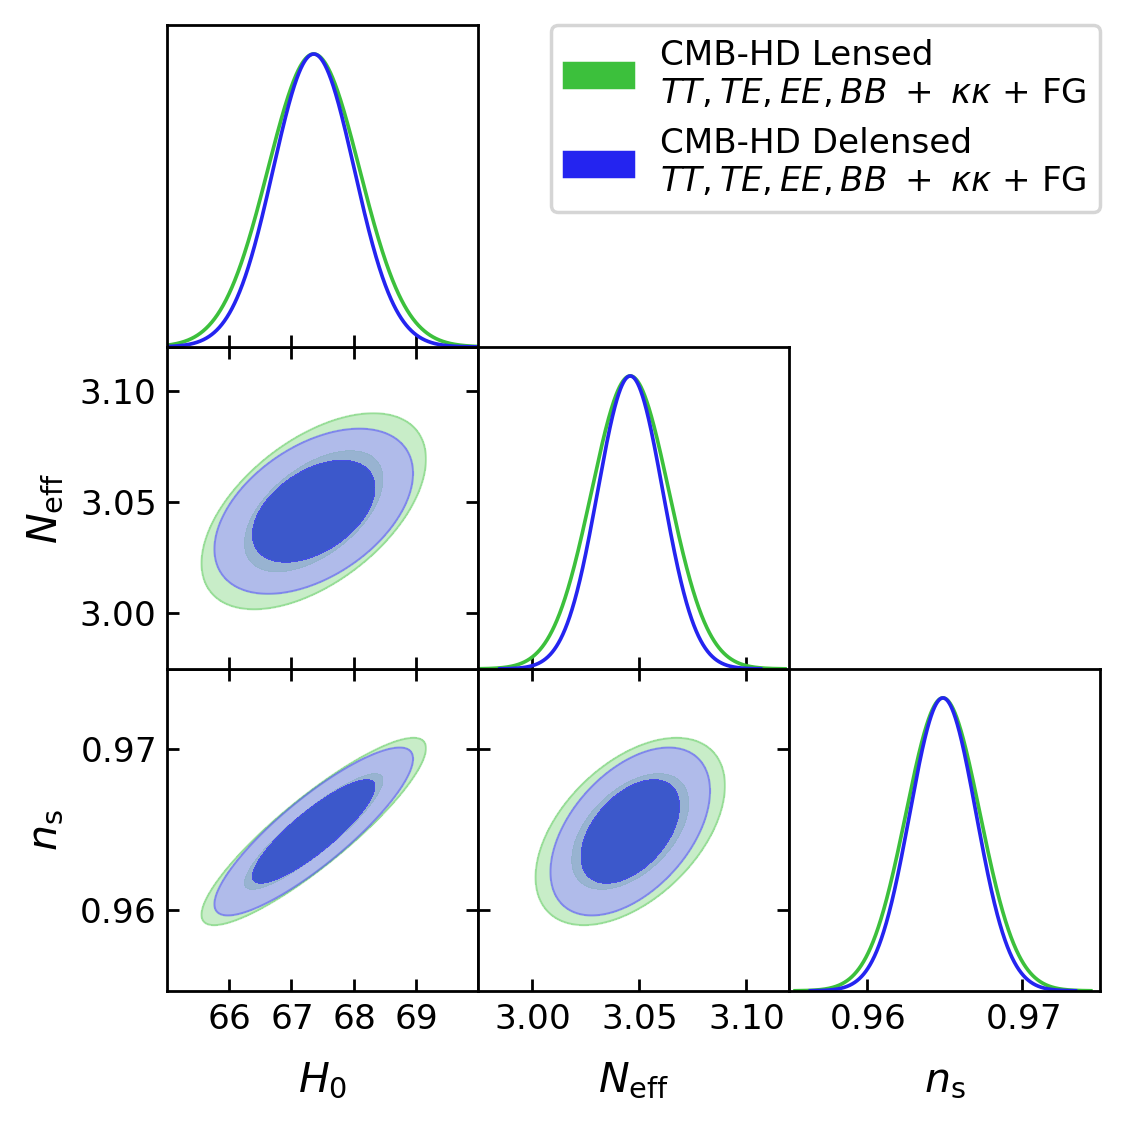

In [25]:
legend_labels = ['CMB-HD Lensed\n' + r'$TT, TE, EE, BB~+~\kappa\kappa$ + FG', 
                 'CMB-HD Delensed\n' + r'$TT, TE, EE, BB~+~\kappa\kappa$ + FG']
plt_colors = [green, blue]
plt_samples = [hd_samples['lensed'], hd_samples['delensed']]

g = ps.get_subplot_plotter(width_inch=4.6)
g.settings.scaling_factor = 1.1
g.settings.axes_fontsize = 12
g.triangle_plot(plt_samples, 
                params=plt_params, 
                filled=True, 
                param_limits=plt_param_lims,
                contour_args={'alpha': 0.7},
                diag1d_kwargs={'lws': [1.05, 1.05]},
                contour_colors=plt_colors, 
                legend_labels=legend_labels)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig09_hd_lensed_delensed.pdf'), bbox_inches='tight', dpi=dpi)
plt.show()

##### [Fig. 10] Delensed + FG and Delensed + FG + BAO

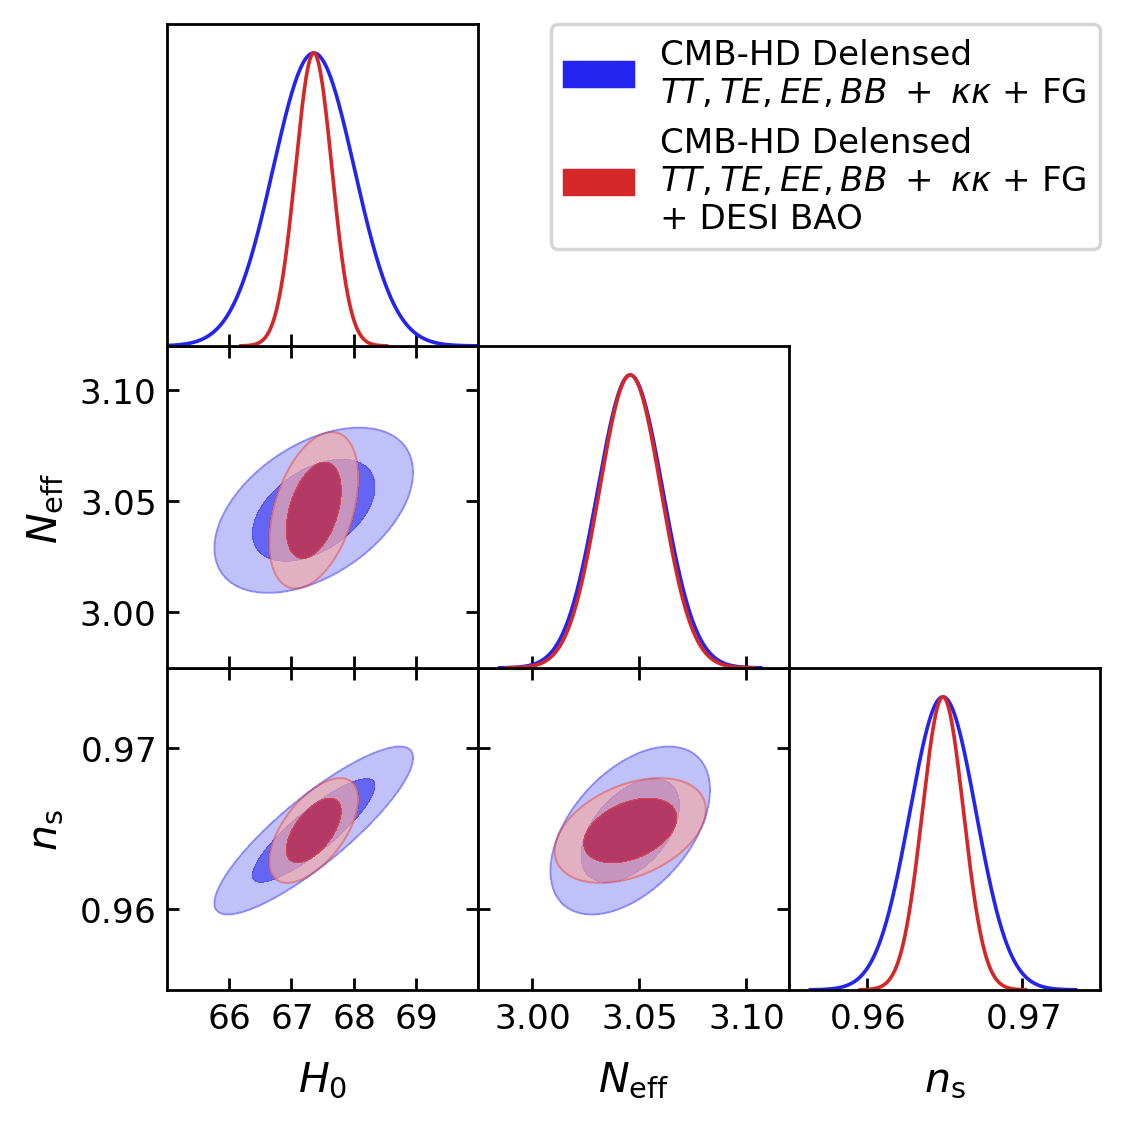

In [26]:
legend_labels = ['CMB-HD Delensed\n' + r'$TT, TE, EE, BB~+~\kappa\kappa$ + FG', 
                 'CMB-HD Delensed\n' + r'$TT, TE, EE, BB~+~\kappa\kappa$ + FG' + '\n+ DESI BAO']
plt_colors = [blue, red]
plt_samples = [hd_samples['delensed'], hd_samples['delensed_desi']]

g = ps.get_subplot_plotter(width_inch=4.6)
g.settings.scaling_factor = 1.1
g.settings.axes_fontsize = 12
g.triangle_plot(plt_samples, 
                params=plt_params, 
                filled=True, 
                param_limits=plt_param_lims,
                contour_args={'alpha': 0.7},
                diag1d_kwargs={'lws': [1.05, 1.05]},
                contour_colors=plt_colors, 
                legend_labels=legend_labels)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig10_hd_delensed_desi.pdf'), bbox_inches='tight', dpi=dpi)
plt.show()

## $\Lambda$CDM + $N_\mathrm{eff}$ + $\sum m_\nu$ + baryonic feedback model

### CMB-HD-like delensed $TT$, $TE$, $EE$, $BB$ and $\kappa\kappa$ + mock DESI BAO

Below, we load in the Fisher matrix that includes the HMCode2020 baryonic feedback parameter $\log_{10}(T_\mathrm{AGN}/\mathrm{K})$ in addition to the $\Lambda$CDM + $N_\mathrm{eff}$ + $\sum m_\nu$ parameters. We use this to get the forecasted parameter uncertainties for this model, with and without a 0.06% prior applied to $\log_{10}(T_\mathrm{AGN}/\mathrm{K})$ (note that the $\tau$ prior of $\sigma(\tau) = 0.007$ has already been applied to all CMB Fisher matrices).

In [27]:
# load the fisher matrix
hd_fishers['delensed_desi_feedback'], hd_fisher_params['delensed_desi_feedback'] = data.load_precomputed_cmb_fisher('hd', cmb_type='delensed', with_desi=True, feedback=True, use_H0=True)


# without SZ prior:
hd_param_errors['delensed_desi_feedback'] = fisher.get_fisher_errors(hd_fishers['delensed_desi_feedback'], hd_fisher_params['delensed_desi_feedback'])
hd_samples['delensed_desi_feedback'] = getdist_samples(hd_fishers['delensed_desi_feedback'], hd_fisher_params['delensed_desi_feedback'])

# with SZ prior:
feedback_prior = {'HMCode_logT_AGN': 0.0006 * fid_params['HMCode_logT_AGN']}
hd_fishers['delensed_desi_feedback_prior'] = fisher.add_priors(hd_fishers['delensed_desi_feedback'], hd_fisher_params['delensed_desi_feedback'], feedback_prior)
hd_param_errors['delensed_desi_feedback_prior'] = fisher.get_fisher_errors(hd_fishers['delensed_desi_feedback_prior'], hd_fisher_params['delensed_desi_feedback'])
hd_samples['delensed_desi_feedback_prior'] = getdist_samples(hd_fishers['delensed_desi_feedback_prior'], hd_fisher_params['delensed_desi_feedback'])

#### [Table 5]

In [28]:
title = 'CMB-HD delensed TT, TE, EE, BB, kk + FG + DESI BAO'
columns = ['CDM', 'CDM + feedback', 'CDM + feedback + SZ prior']
hd_keys = ['delensed_desi', 'delensed_desi_feedback', 'delensed_desi_feedback_prior']
param_errors_list = [round_dict(hd_param_errors[key]) for key in hd_keys]
print_table(param_errors_list, columns, title=title, list_of_keys=param_list+['HMCode_logT_AGN'])



 CMB-HD delensed TT, TE, EE, BB, kk + FG + DESI BAO


,CDM,CDM + feedback,CDM + feedback + SZ prior
ombh2,0.000026,0.000027,0.000026
omch2,0.000410,0.000450,0.000410
logA,0.009800,0.010800,0.010700
ns,0.001300,0.001900,0.001300
tau,0.005200,0.005700,0.005600
H0,0.290000,0.290000,0.280000
nnu,0.014000,0.019000,0.015000
mnu,0.025000,0.028000,0.028000
HMCode_logT_AGN,NaN,0.035600,0.004600


#### [Fig. 12]

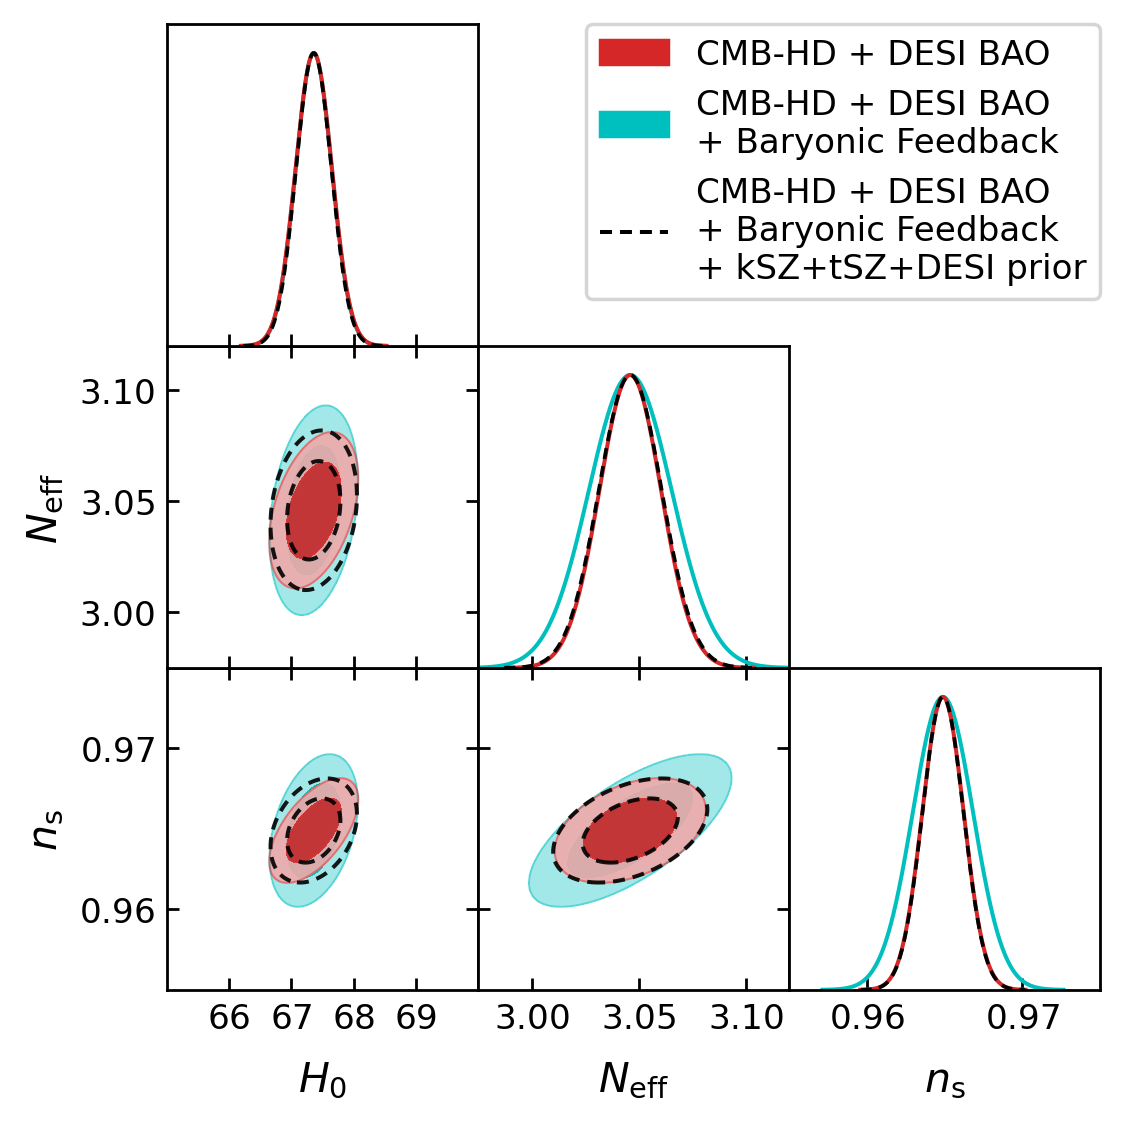

In [29]:
legend_labels = ['CMB-HD + DESI BAO\n+ Baryonic Feedback',
                 'CMB-HD + DESI BAO',
                 'CMB-HD + DESI BAO\n+ Baryonic Feedback\n+ kSZ+tSZ+DESI prior']
plt_samples = [hd_samples['delensed_desi_feedback'], hd_samples['delensed_desi'], hd_samples['delensed_desi_feedback_prior']]
plt_colors = ['c', red, 'k']
lines = ['-', '-', '--']
lws = [1.05, 1.05, 1.15]
alphas = [0.9, 0.9, 0.9]

g = ps.get_subplot_plotter(width_inch=4.6)
g.settings.scaling_factor = 1.1
g.settings.axes_fontsize = 12
g.triangle_plot(plt_samples, 
                params=plt_params, 
                filled=[True, True, False], 
                param_limits=plt_param_lims,
                diag1d_kwargs={'lws': [1.15, 1.15, 1.05], 'ls': lines},
                contour_args={'ls': lines},
                ls=lines, lws=lws, alphas=alphas,
                contour_colors=plt_colors,
                label_order=[1, 0, 2], 
                legend_labels=legend_labels)
if save_plots:
    plt.savefig(plot_path(f'{plot_root}_fig12_hd_delensed_desi_feedback.pdf'), bbox_inches='tight', dpi=dpi)
plt.show()

## $\Lambda$CDM and $\Lambda$CDM + $N_\mathrm{eff}$ models

### CMB-HD-like $TT$, $TE$, $EE$, $BB$, $\kappa\kappa$ (+ mock DESI BAO)




In [30]:
hd_fishers_lcdm_nnu = {}
hd_fisher_params_lcdm_nnu = {}
hd_param_errors_lcdm_nnu = {}

for cmb_type in ['lensed', 'delensed']:
    # without bao:
    hd_fishers_lcdm_nnu[cmb_type], hd_fisher_params_lcdm_nnu[cmb_type] = fisher.remove_params(hd_fishers[cmb_type], hd_fisher_params[cmb_type], ['mnu'])
    hd_param_errors_lcdm_nnu[cmb_type] = fisher.get_fisher_errors(hd_fishers_lcdm_nnu[cmb_type], hd_fisher_params_lcdm_nnu[cmb_type])
    # with bao:
    hd_fishers_lcdm_nnu[f'{cmb_type}_desi'], hd_fisher_params_lcdm_nnu[f'{cmb_type}_desi'] = fisher.remove_params(hd_fishers[f'{cmb_type}_desi'], hd_fisher_params[f'{cmb_type}_desi'], ['mnu'])
    hd_param_errors_lcdm_nnu[f'{cmb_type}_desi'] = fisher.get_fisher_errors(hd_fishers_lcdm_nnu[f'{cmb_type}_desi'], hd_fisher_params_lcdm_nnu[f'{cmb_type}_desi'])
# lensed, without FG or bao:
hd_fishers_lcdm_nnu['lensed_nofg'], hd_fisher_params_lcdm_nnu['lensed_nofg'] = fisher.remove_params(hd_fishers['lensed_nofg'], hd_fisher_params['lensed_nofg'], ['mnu'])
hd_param_errors_lcdm_nnu['lensed_nofg'] = fisher.get_fisher_errors(hd_fishers_lcdm_nnu['lensed_nofg'], hd_fisher_params_lcdm_nnu['lensed_nofg'])
# delensed with bao for lmax = 10,000:
hd_lmax = 10000
hd_fishers_lcdm_nnu[f'delensed_desi_{hd_lmax}'], hd_fisher_params_lcdm_nnu[f'delensed_desi_{hd_lmax}'] = fisher.remove_params(hd_fishers[f'delensed_desi_{hd_lmax}'], hd_fisher_params[f'delensed_desi_{hd_lmax}'], ['mnu'])
hd_param_errors_lcdm_nnu[f'delensed_desi_{hd_lmax}'] = fisher.get_fisher_errors(hd_fishers_lcdm_nnu[f'delensed_desi_{hd_lmax}'], hd_fisher_params_lcdm_nnu[f'delensed_desi_{hd_lmax}'])




In [31]:
hd_fishers_lcdm = {}
hd_fisher_params_lcdm = {}
hd_param_errors_lcdm = {}

for cmb_type in ['lensed', 'delensed']:
    # without bao:
    hd_fishers_lcdm[cmb_type], hd_fisher_params_lcdm[cmb_type] = fisher.remove_params(hd_fishers[cmb_type], hd_fisher_params[cmb_type], ['nnu', 'mnu'])
    hd_param_errors_lcdm[cmb_type] = fisher.get_fisher_errors(hd_fishers_lcdm[cmb_type], hd_fisher_params_lcdm[cmb_type])
    # with bao:
    hd_fishers_lcdm[f'{cmb_type}_desi'], hd_fisher_params_lcdm[f'{cmb_type}_desi'] = fisher.remove_params(hd_fishers[f'{cmb_type}_desi'], hd_fisher_params[f'{cmb_type}_desi'], ['nnu', 'mnu'])
    hd_param_errors_lcdm[f'{cmb_type}_desi'] = fisher.get_fisher_errors(hd_fishers_lcdm[f'{cmb_type}_desi'], hd_fisher_params_lcdm[f'{cmb_type}_desi'])
# lensed, without FG or bao:
hd_fishers_lcdm['lensed_nofg'], hd_fisher_params_lcdm['lensed_nofg'] = fisher.remove_params(hd_fishers['lensed_nofg'], hd_fisher_params['lensed_nofg'], ['nnu', 'mnu'])
hd_param_errors_lcdm['lensed_nofg'] = fisher.get_fisher_errors(hd_fishers_lcdm['lensed_nofg'], hd_fisher_params_lcdm['lensed_nofg'])
# delensed with bao for lmax = 10,000:
hd_lmax = 10000
hd_fishers_lcdm[f'delensed_desi_{hd_lmax}'], hd_fisher_params_lcdm[f'delensed_desi_{hd_lmax}'] = fisher.remove_params(hd_fishers[f'delensed_desi_{hd_lmax}'], hd_fisher_params[f'delensed_desi_{hd_lmax}'], ['nnu', 'mnu'])
hd_param_errors_lcdm[f'delensed_desi_{hd_lmax}'] = fisher.get_fisher_errors(hd_fishers_lcdm[f'delensed_desi_{hd_lmax}'], hd_fisher_params_lcdm[f'delensed_desi_{hd_lmax}'])




#### [Tables 7 and 8]

In [32]:
title = 'CMB-HD TT, TE, EE, BB, kk'
columns = ['Lensed', 'Lensed + FG', 'Delensed + FG', 
           'Delensed + FG + DESI BAO', 'Delensed + FG + DESI BAO (lmax = 10,000)']
hd_keys = ['lensed_nofg', 'lensed', 'delensed', 
           'delensed_desi', 'delensed_desi_10000']


param_errors_list = [round_dict(hd_param_errors_lcdm_nnu[key]) for key in hd_keys]
print_table(param_errors_list, columns, title=title, list_of_keys=param_list[:-1])

param_errors_list = [round_dict(hd_param_errors_lcdm[key]) for key in hd_keys]
print_table(param_errors_list, columns, title=title, list_of_keys=param_list[:-2])



 CMB-HD TT, TE, EE, BB, kk


,Lensed,Lensed + FG,Delensed + FG,Delensed + FG + DESI BAO,"Delensed + FG + DESI BAO (lmax = 10,000)"
ombh2,0.000032,0.000033,0.000027,0.000026,0.000026
omch2,0.000510,0.000520,0.000470,0.000410,0.000410
logA,0.007800,0.008000,0.007500,0.006200,0.006300
ns,0.001300,0.001500,0.001500,0.001300,0.001400
tau,0.004500,0.004600,0.004300,0.003600,0.003600
H0,0.210000,0.220000,0.210000,0.180000,0.190000
nnu,0.016000,0.017000,0.015000,0.014000,0.015000



 CMB-HD TT, TE, EE, BB, kk


,Lensed,Lensed + FG,Delensed + FG,Delensed + FG + DESI BAO,"Delensed + FG + DESI BAO (lmax = 10,000)"
ombh2,0.000017,0.000018,0.000017,0.000017,0.000017
omch2,0.000460,0.000480,0.000450,0.000370,0.000380
logA,0.007800,0.008000,0.007400,0.006200,0.006300
ns,0.001300,0.001400,0.001300,0.001200,0.001300
tau,0.004500,0.004600,0.004300,0.003600,0.003600
H0,0.170000,0.180000,0.170000,0.140000,0.140000
